###  importing relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
import sklearn
import time
import os
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix


### Discovering Labels

In [3]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    df["Label"]=df["Label"].replace(renamer)
    df=df.dropna()
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [4]:
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")

In [5]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

In [6]:
renamer={'Amazon Alexa Echo Dot 1': "Amazon Alexa Echo Dot",
 'Amazon Alexa Echo Dot 2': "Amazon Alexa Echo Dot",
 'D-Link DCHS-161 Water Sensor': 'D-Link Water Sensor',
 'DCS8000LHA1 D-Link Mini Camera': 'D-Link Mini Camera',
 'Gosund ESP_032979 Plug':'Gosund Plug',
 'Gosund ESP_039AAF Socket':'Gosund Socket',
 'Gosund ESP_0C3994 Plug': 'Gosund Plug',
 'Gosund ESP_10098F Socket':'Gosund Socket',
 'Gosund ESP_10ACD8 Plug':'Gosund Plug',
 'Gosund ESP_147FF9 Plug': 'Gosund Plug',
 'Gosund ESP_1ACEE1  Socket':'Gosund Socket',
 'Philips Hue Bridge 1': "Philips Hue Bridge",
 'Philips Hue Bridge 2': "Philips Hue Bridge",
 'Philips Hue White 1': "Philips Hue White",
 'Philips Hue White 2':"Philips Hue White",
 'Ring Base Station AC:1236': 'Ring Base Station',
 'Sengled Smart Plug 1': 'Sengled Smart Plug',
 'Sengled Smart Plug 2': 'Sengled Smart Plug',
 'SmartThings Smart Bulb 1': 'SmartThings Smart Bulb',
 'SmartThings Smart Bulb 2': 'SmartThings Smart Bulb',
 'SmartThings Smart Bulb 3': 'SmartThings Smart Bulb',
 'SmartThings Smart Bulb 4': 'SmartThings Smart Bulb',
 'SmartThings Smart Bulb 5': 'SmartThings Smart Bulb',
 'Sonoff Smart Plug 1': 'Sonoff Smart Plug',
 'Sonoff Smart Plug 2': 'Sonoff Smart Plug',
 'Teckin Plug 1':'Teckin Plug',
 'Teckin Plug 2':'Teckin Plug',
 'Yutron Plug 1': 'Yutron Plug',
 'Yutron Plug 2':  'Yutron Plug'}

In [7]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second

## Calculation of evaluations

In [8]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ml):
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,i,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time,altime]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return line,class_based_results

In [9]:


def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif
 
# Driver Code
#li1 = [10, 15, 20, 25, 30, 35, 40]
#li2 = [25, 40, 35]


In [10]:
def ML(loop1,loop2,output_csv1,cols,step,mixed,dname):

    
    for ii in ml_list:

        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        output_csv=output_csv1.replace("ML",ii)
        repetition=10
        lines=[["Dataset","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T","Al-Time"]]
        for i in range(repetition):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            df=df.dropna()
            df["Label"]=df["Label"].replace(renamer)
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  
            
            

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            df=df.dropna()
            df["Label"]=df["Label"].replace(renamer)
            df = shuffle(df, random_state=42)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes


            results_y=[]
            cv+=1
            results_y.append(y_test)


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
                
                
            lines.append(line)
            df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/(repetition)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
  
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","CB.csv"))
        if True:
            cm=cm//repetition
            graph_name=output_csv+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            #print("\n\n\n")             


            #plt.clf()

            
            
            
            
            



# Machine learning applications 

# Aalto Dataset

In [11]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


In [12]:
ml_list={"DT" :DecisionTreeClassifier()}


In [13]:
find_the_way("./","clean")

[]

In [14]:
file_list={"DD11":['./small/AD-S1.csv','./small/DI-S1.csv','./small/DI-S2.csv'],
"DD11T":['./small/DI-S1.csv','./small/AD-S1.csv','./small/AD-S2.csv'],
"DD12":['./small/AD-S1.csv','./small/DI-S2.csv','./small/DI-S1.csv'],
"DD12T":['./small/DI-S2.csv','./small/AD-S1.csv','./small/AD-S2.csv'],
"DD22":['./small/AD-S2.csv','./small/DI-S2.csv','./small/DI-S1.csv'],
"DD22T":['./small/DI-S2.csv','./small/AD-S2.csv','./small/AD-S1.csv'],
"DD21":['./small/AD-S2.csv','./small/DI-S1.csv','./small/DI-S2.csv'],
"DD21T":['./small/DI-S1.csv','./small/AD-S2.csv','./small/AD-S1.csv']}
# In[48]:

In [18]:
file_list[ii][1][8:-4]

'DI-S1'

AD-S1-DI-S1
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.716    0.728   0.743  0.728  0.692  0.699      0    0.587     0.069          0
 1  results/other/1_1    1     2  DT    0.715    0.728   0.742  0.728  0.691  0.699      0    0.585     0.059          0
 2  results/other/1_1    2     3  DT    0.716    0.729   0.742  0.729  0.692  0.7        0    0.575     0.049          0
 3  results/other/1_1    3     4  DT    0.716    0.728   0.742  0.728  0.691  0.699      0    0.479     0.051          0
 4  results/other/1_1    4     5  DT    0.716    0.729   0.742  0.729  0.692  0.699      0    0.598     0.06           0
 5  results/other/1_1    5     6  DT    0.716    0.728   0.741  0.728  0.691  0.699      0    0.581     0.047          0
 6  results/other/1_

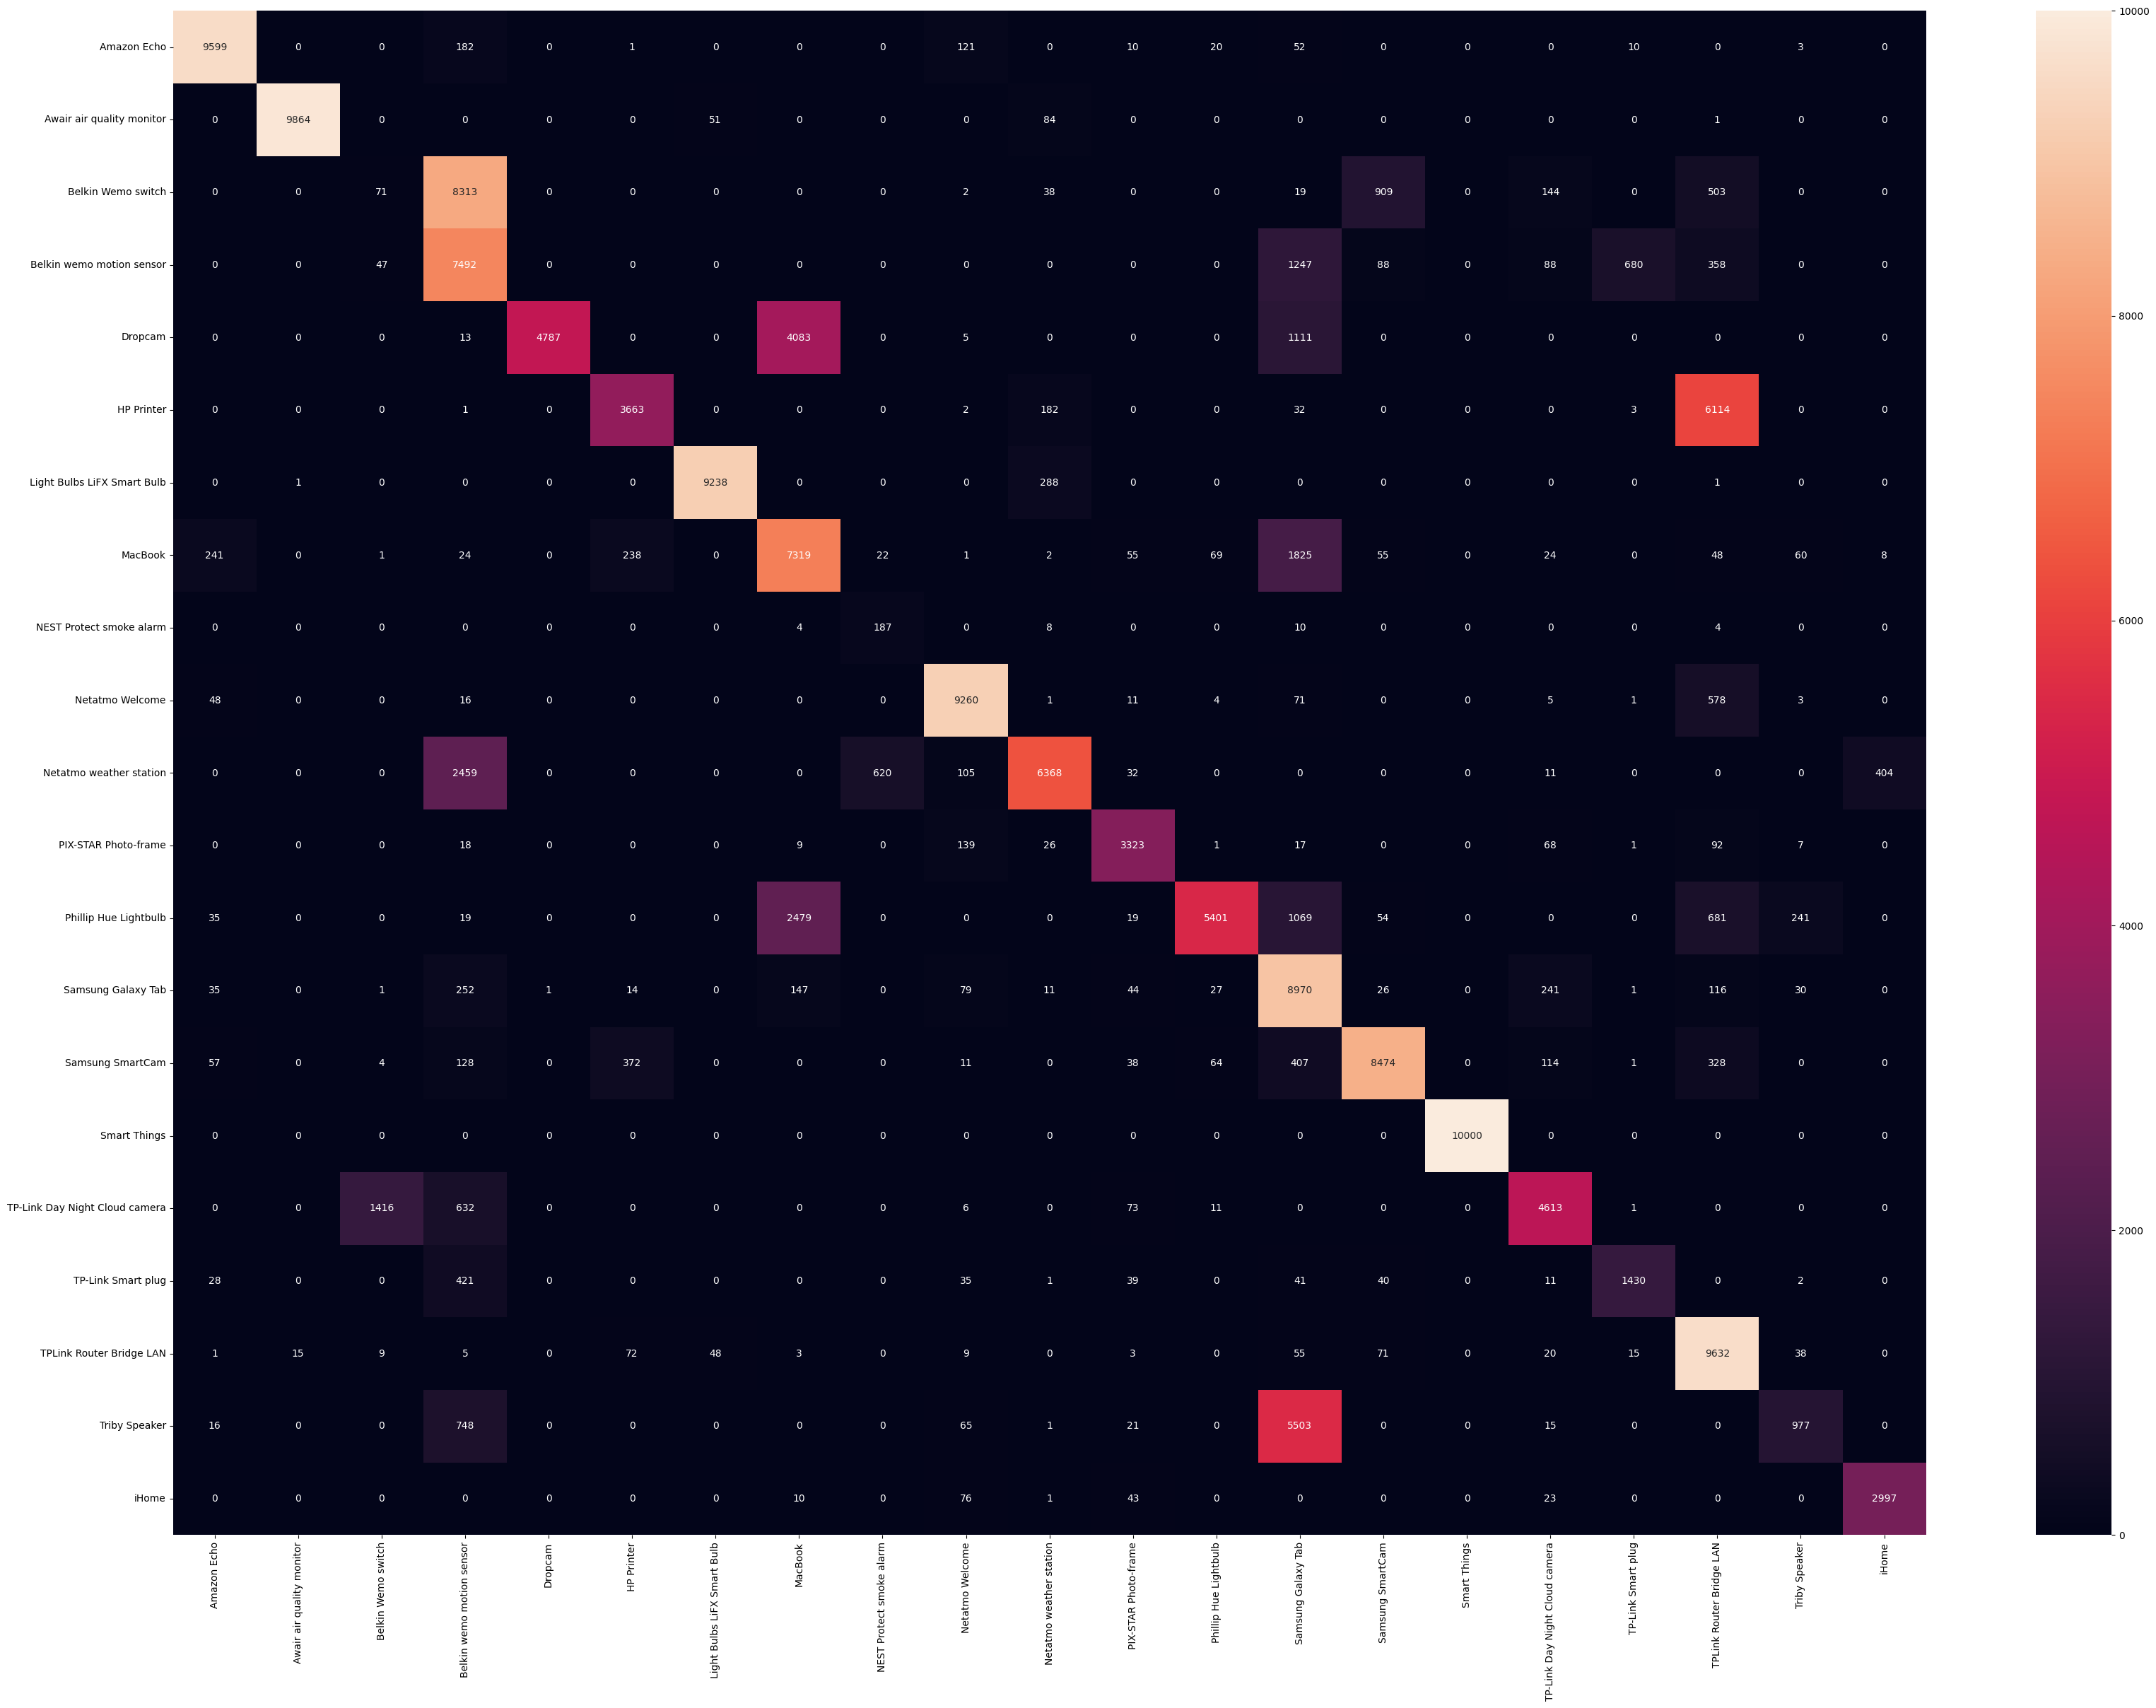

DI-S1-AD-S1
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.636    0.69    0.712  0.69   0.623  0.617      0    0.545     0.048          0
 1  results/other/1_1    1     2  DT    0.639    0.693   0.684  0.693  0.626  0.62       0    0.52      0.045          0
 2  results/other/1_1    2     3  DT    0.633    0.688   0.711  0.688  0.621  0.614      0    0.516     0.065          0
 3  results/other/1_1    3     4  DT    0.639    0.693   0.684  0.693  0.627  0.621      0    0.568     0.046          0
 4  results/other/1_1    4     5  DT    0.639    0.693   0.683  0.693  0.626  0.62       0    0.552     0.056          0
 5  results/other/1_1    5     6  DT    0.633    0.688   0.68   0.688  0.622  0.614      0    0.56      0.043          0
 6  results/other/1_

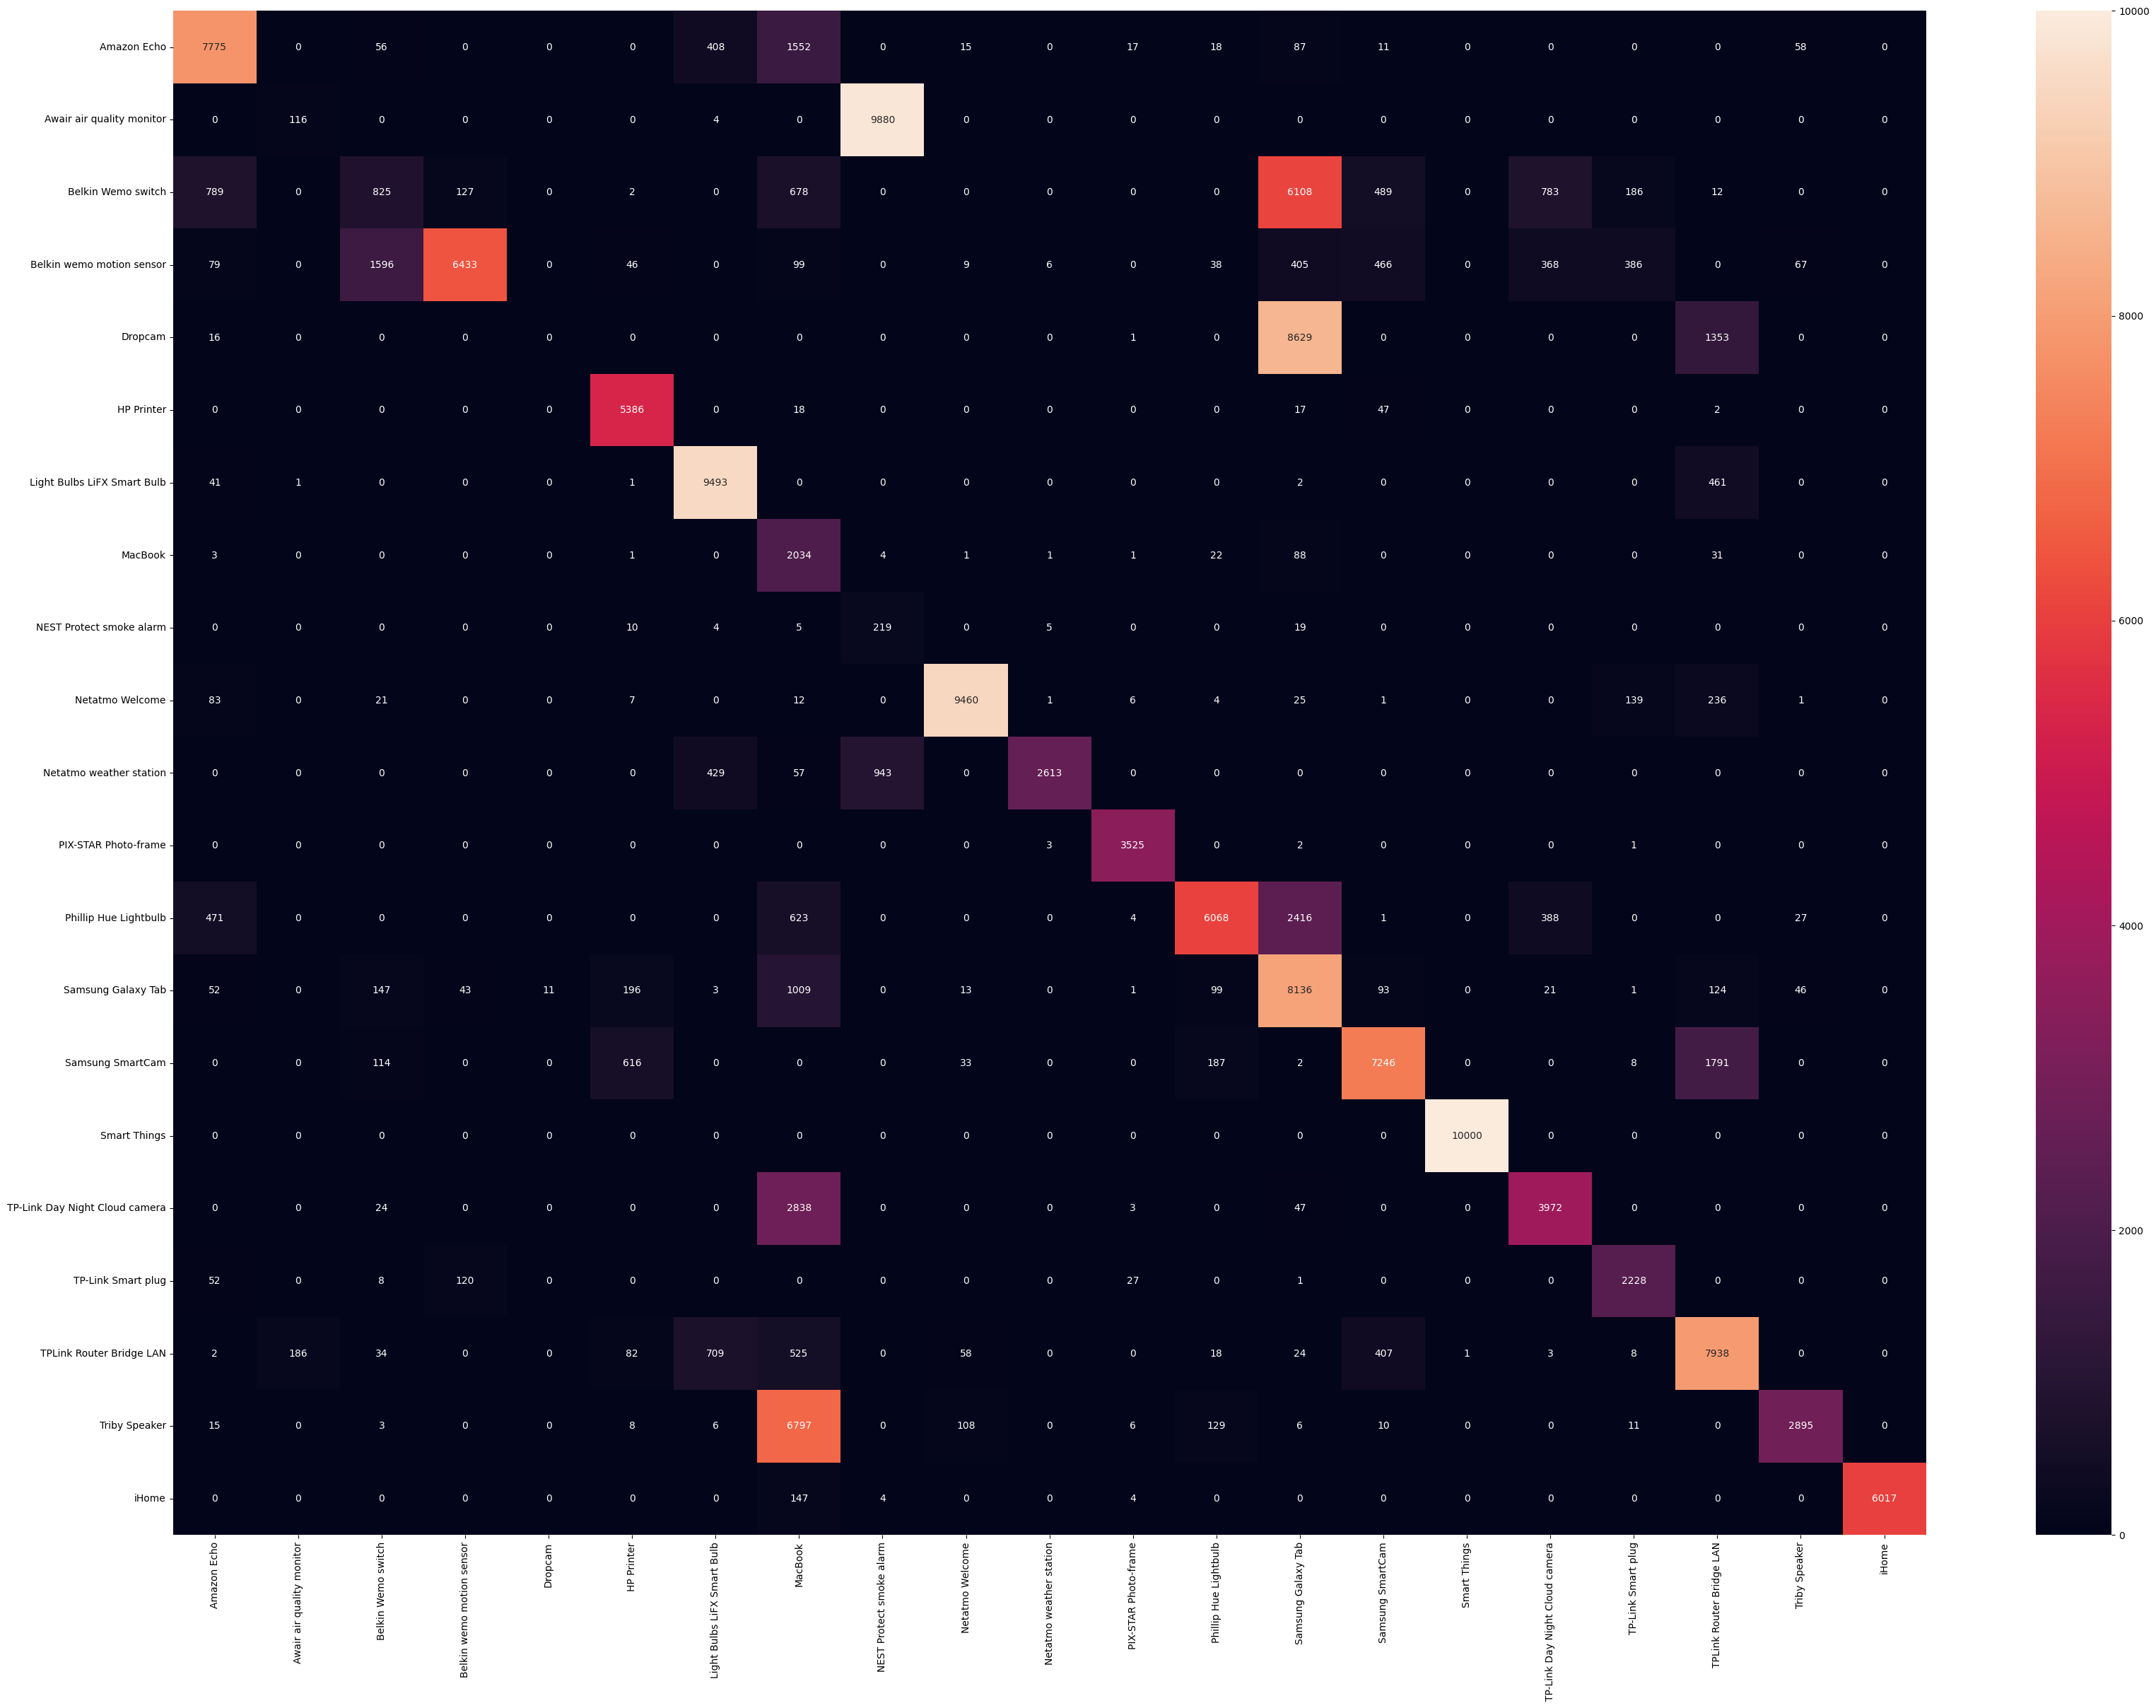

AD-S1-DI-S2
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.72     0.736   0.743  0.736  0.7    0.704      0    0.509     0.055          0
 1  results/other/1_1    1     2  DT    0.723    0.739   0.75   0.739  0.705  0.707      0    0.572     0.052          0
 2  results/other/1_1    2     3  DT    0.723    0.739   0.746  0.739  0.703  0.707      0    0.582     0.051          0
 3  results/other/1_1    3     4  DT    0.725    0.741   0.755  0.741  0.709  0.709      0    0.546     0.052          0
 4  results/other/1_1    4     5  DT    0.723    0.739   0.746  0.739  0.704  0.707      0    0.603     0.059          0
 5  results/other/1_1    5     6  DT    0.721    0.737   0.743  0.737  0.702  0.705      0    0.57      0.059          0
 6  results/other/1_

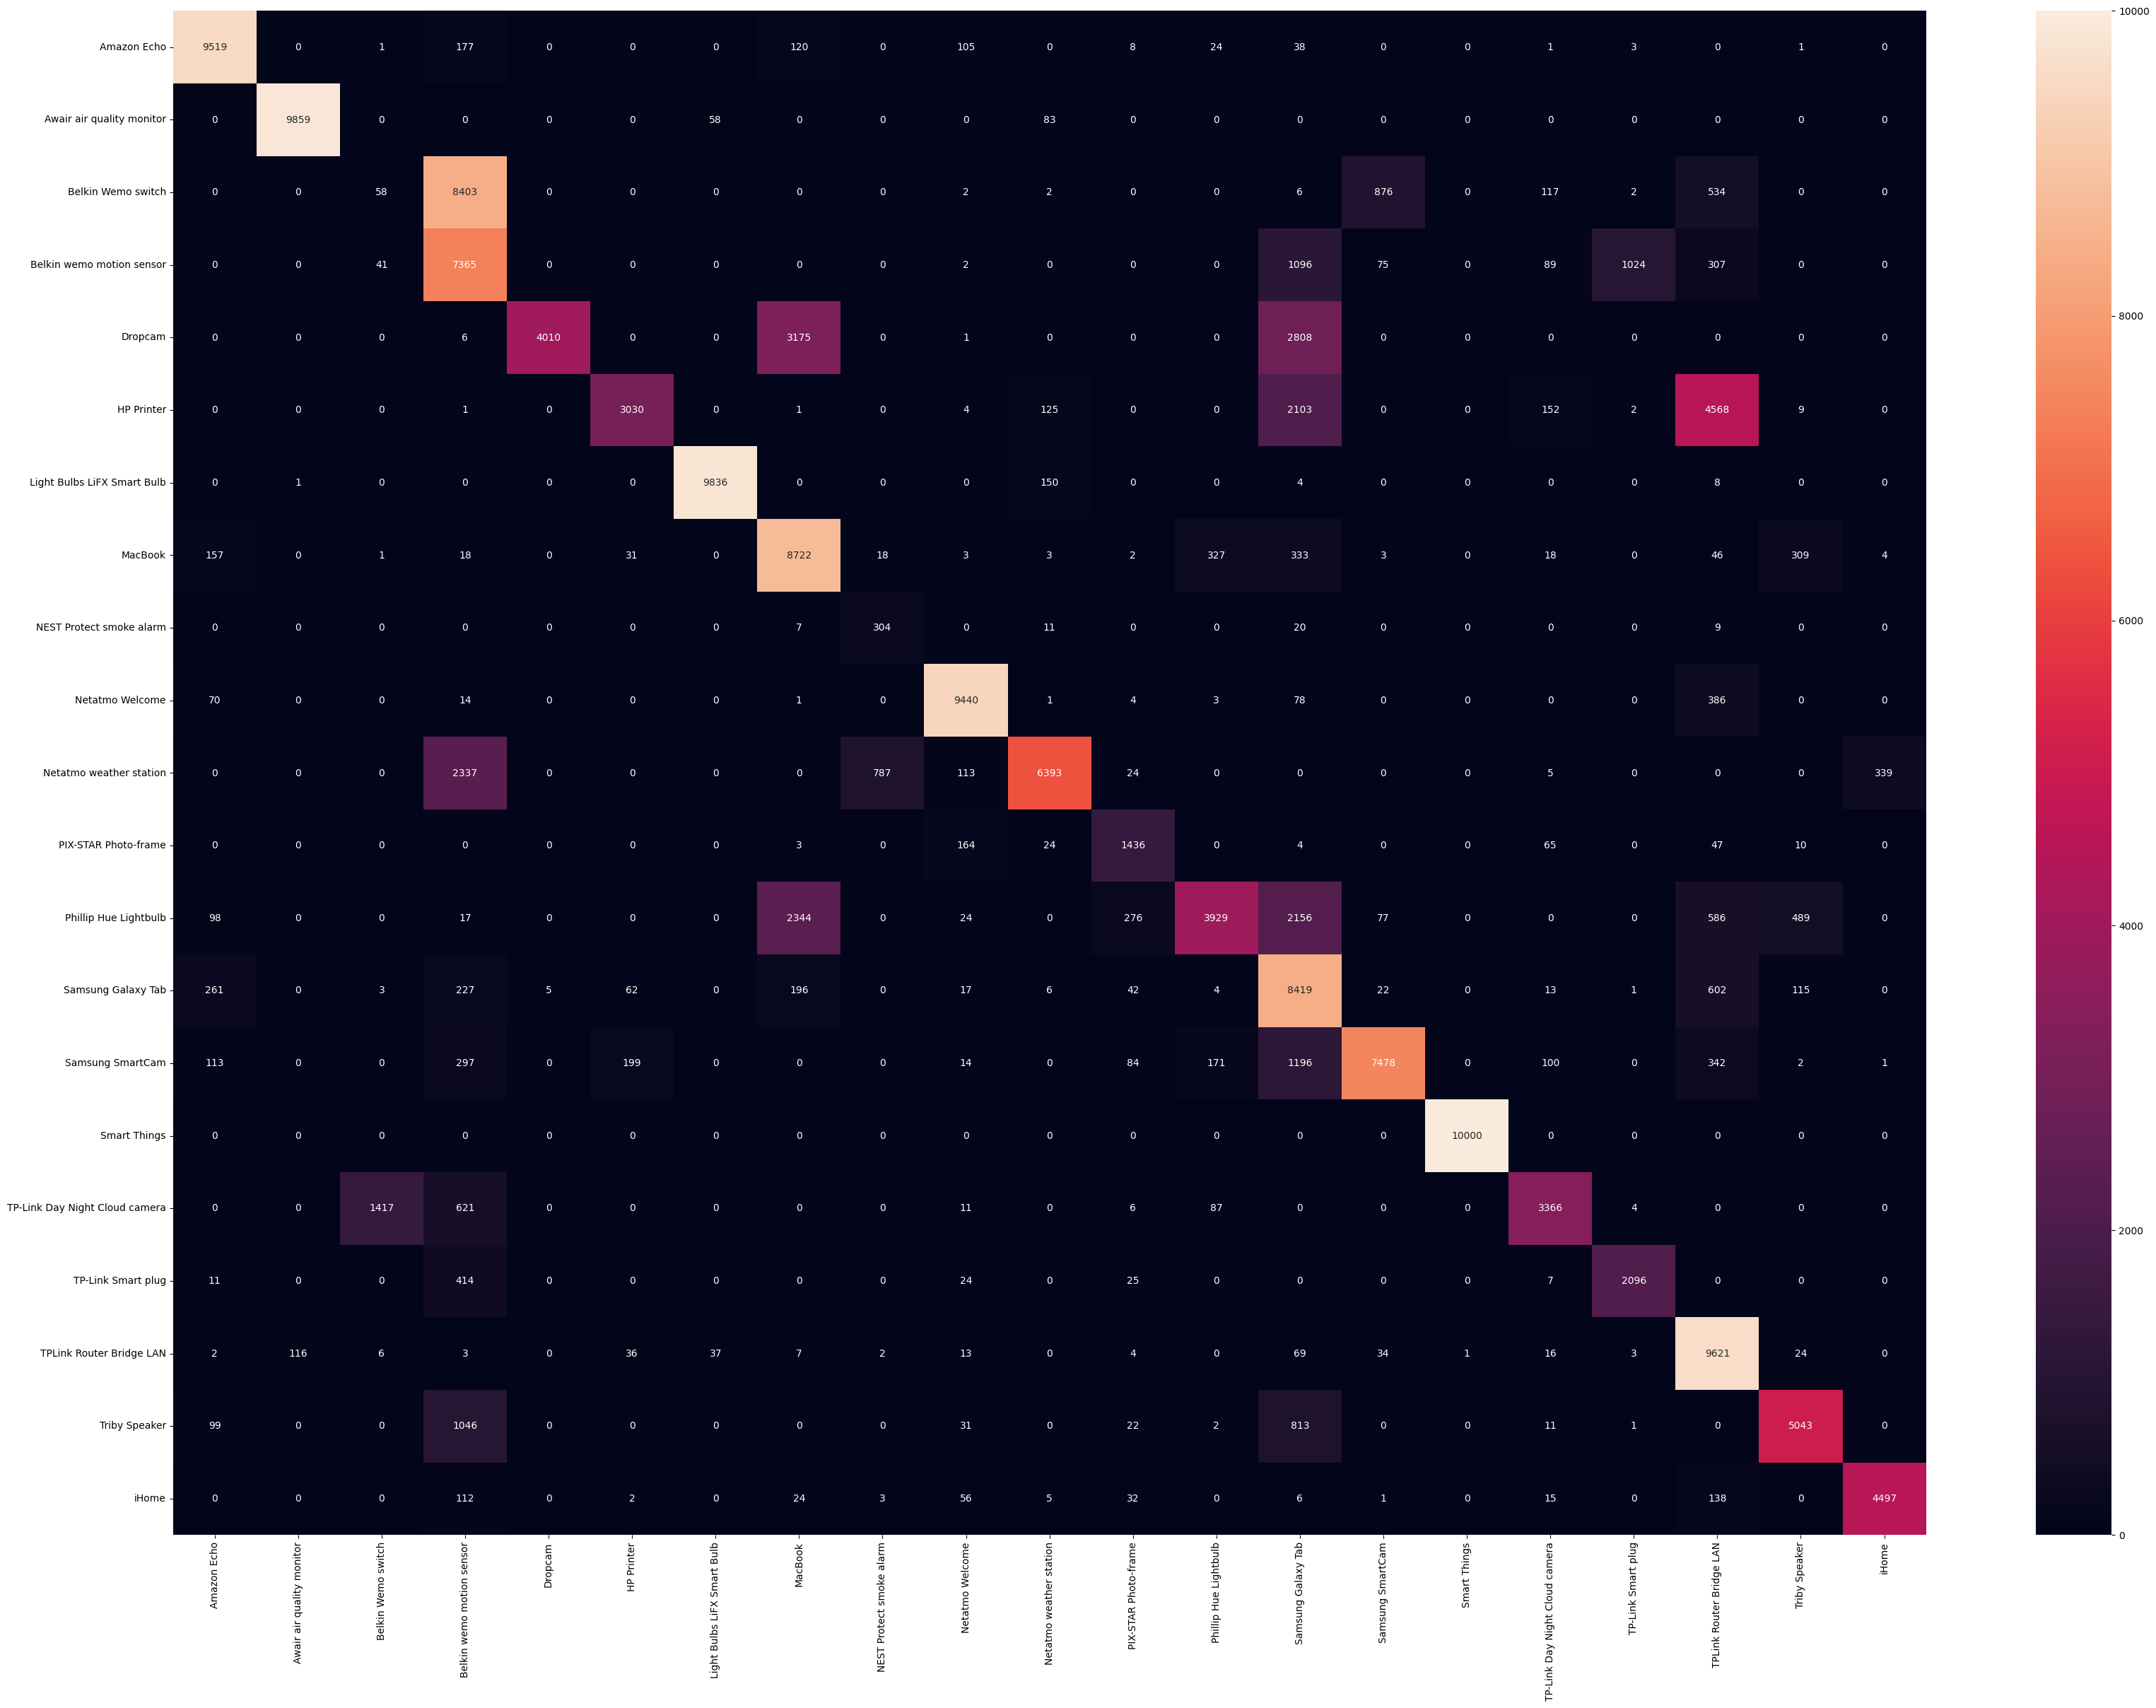

DI-S2-AD-S1
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.625    0.683   0.656  0.683  0.615  0.606      0    0.596     0.048          0
 1  results/other/1_1    1     2  DT    0.635    0.691   0.669  0.691  0.621  0.616      0    0.594     0.047          0
 2  results/other/1_1    2     3  DT    0.638    0.693   0.672  0.693  0.628  0.619      0    0.631     0.041          0
 3  results/other/1_1    3     4  DT    0.636    0.692   0.65   0.692  0.612  0.618      0    0.57      0.042          0
 4  results/other/1_1    4     5  DT    0.625    0.683   0.668  0.683  0.618  0.606      0    0.543     0.056          0
 5  results/other/1_1    5     6  DT    0.625    0.684   0.672  0.684  0.62   0.606      0    0.577     0.061          0
 6  results/other/1_

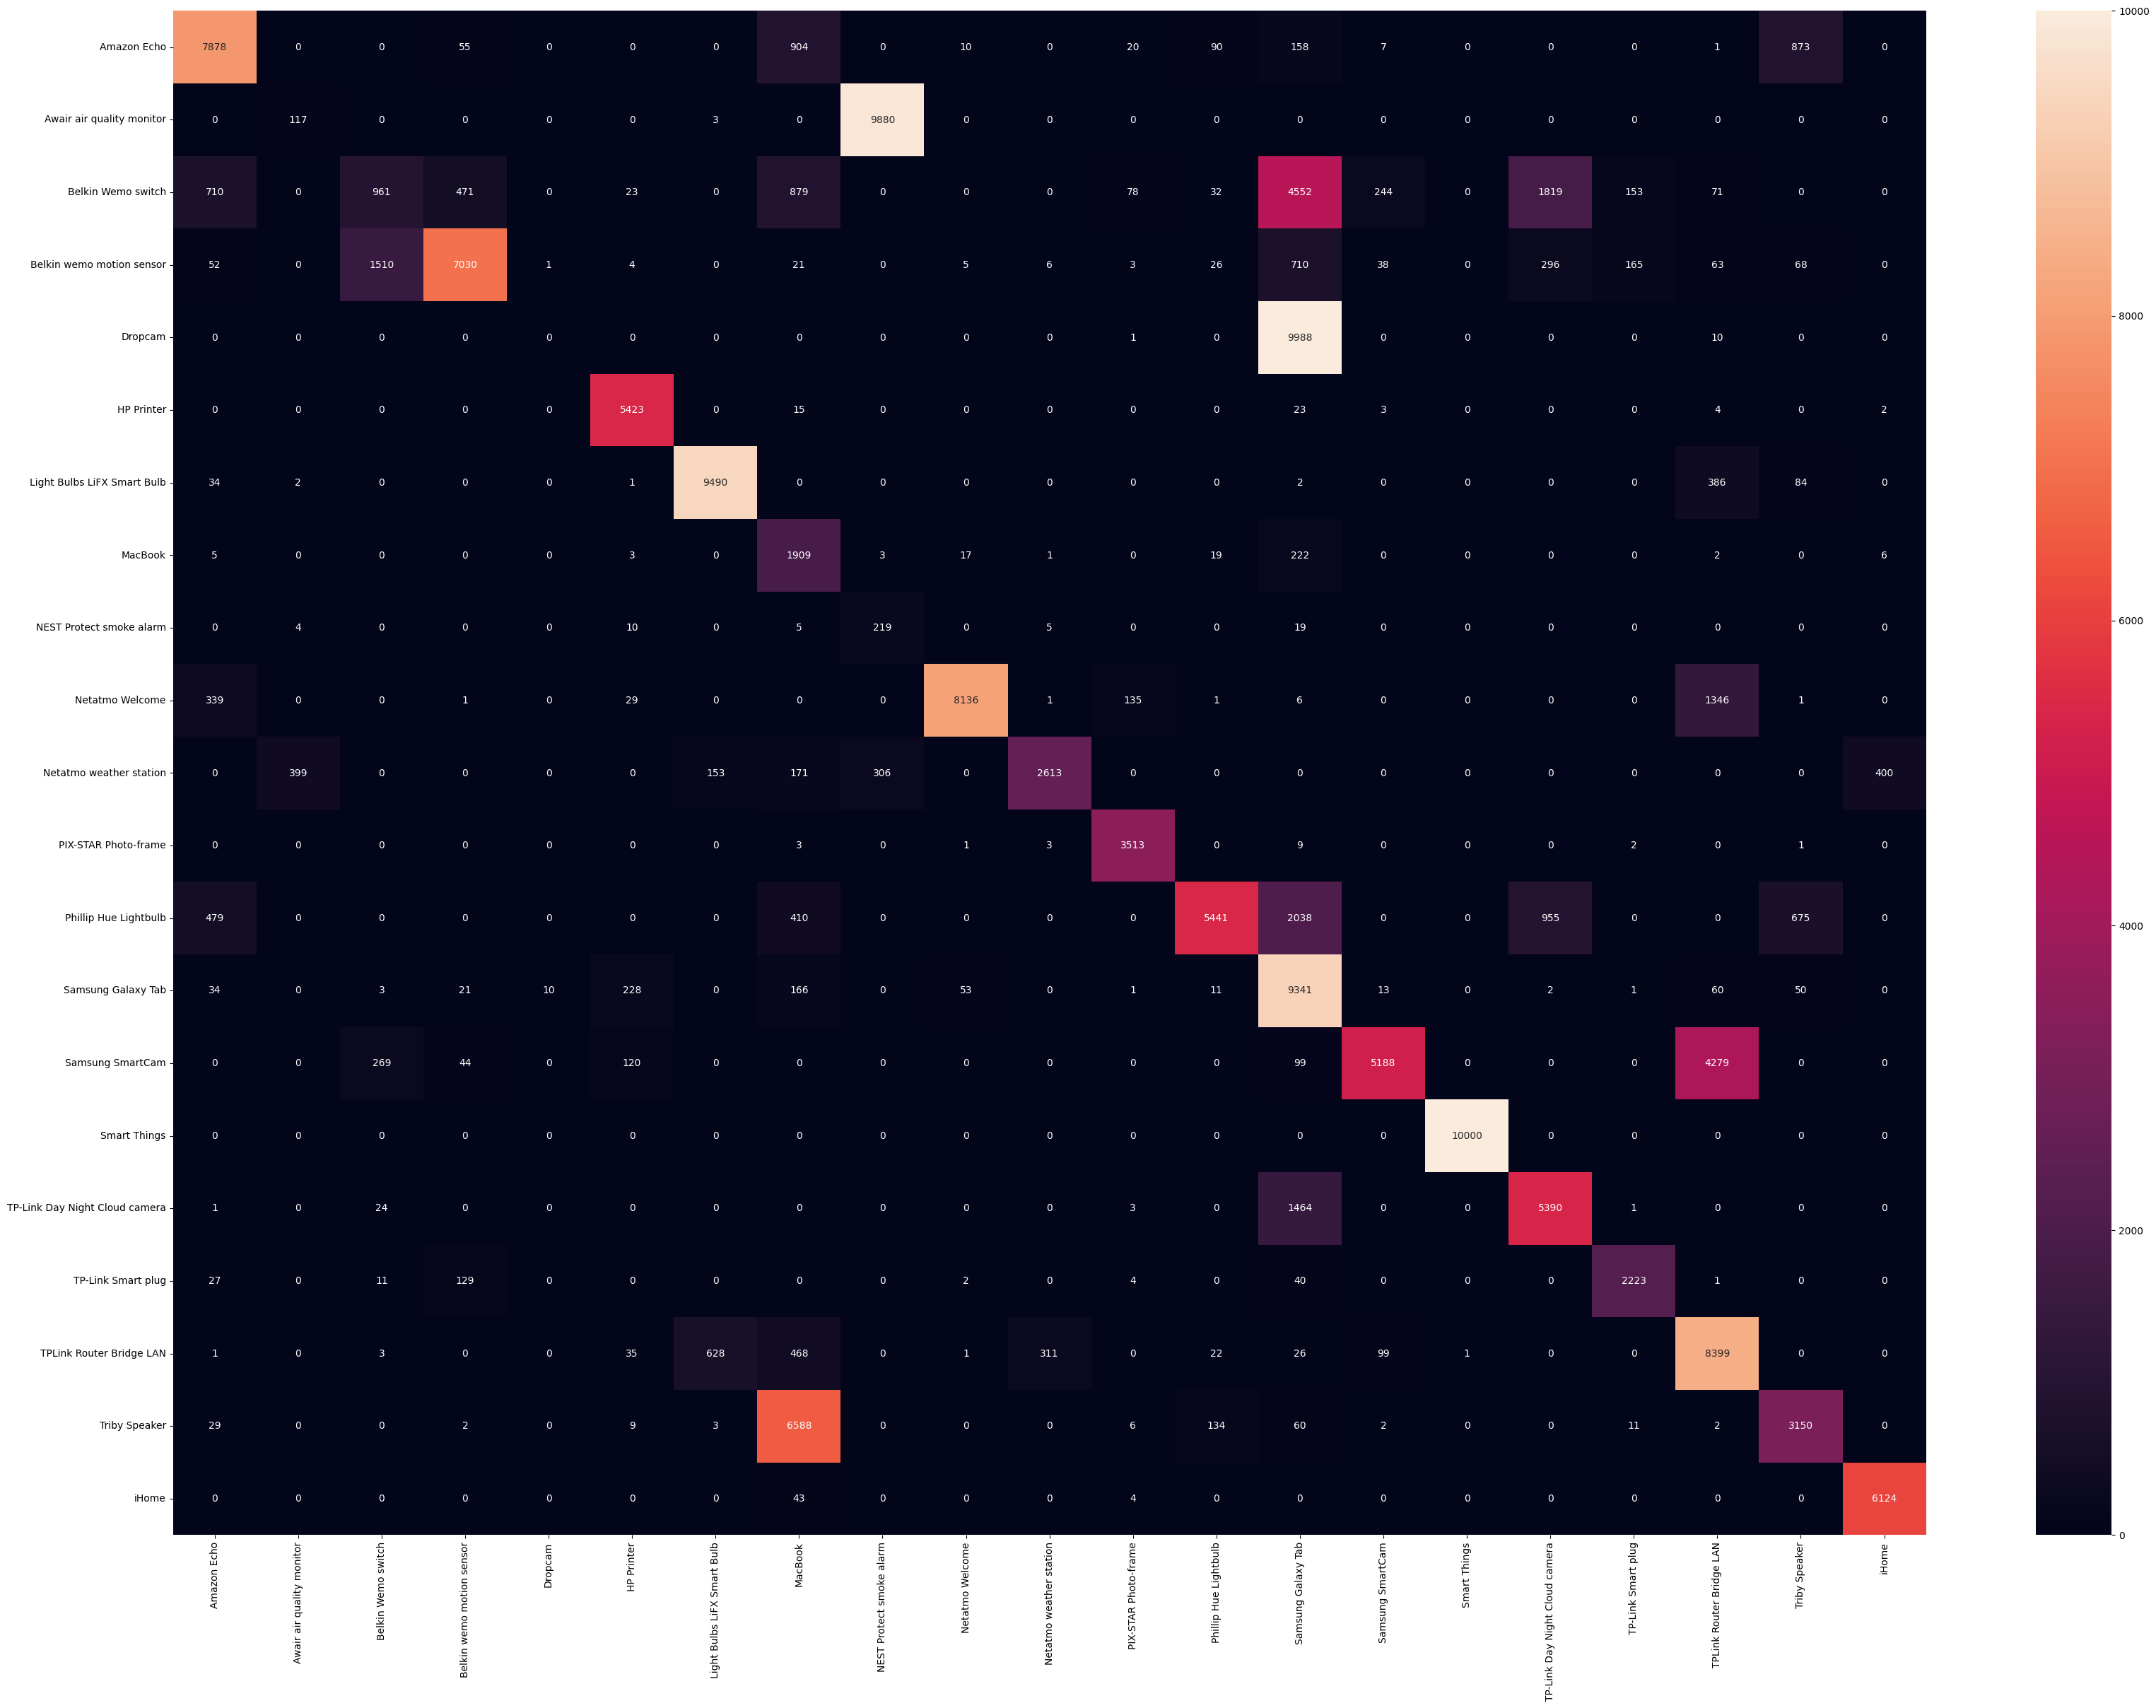

AD-S2-DI-S2
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.636    0.665   0.631  0.665  0.592  0.617      0    0.467     0.052          0
 1  results/other/1_1    1     2  DT    0.634    0.664   0.627  0.664  0.59   0.615      0    0.462     0.055          0
 2  results/other/1_1    2     3  DT    0.638    0.667   0.632  0.667  0.594  0.618      0    0.467     0.042          0
 3  results/other/1_1    3     4  DT    0.637    0.666   0.63   0.666  0.592  0.617      0    0.468     0.046          0
 4  results/other/1_1    4     5  DT    0.639    0.668   0.629  0.668  0.595  0.62       0    0.428     0.047          0
 5  results/other/1_1    5     6  DT    0.636    0.665   0.625  0.665  0.591  0.617      0    0.481     0.046          0
 6  results/other/1_

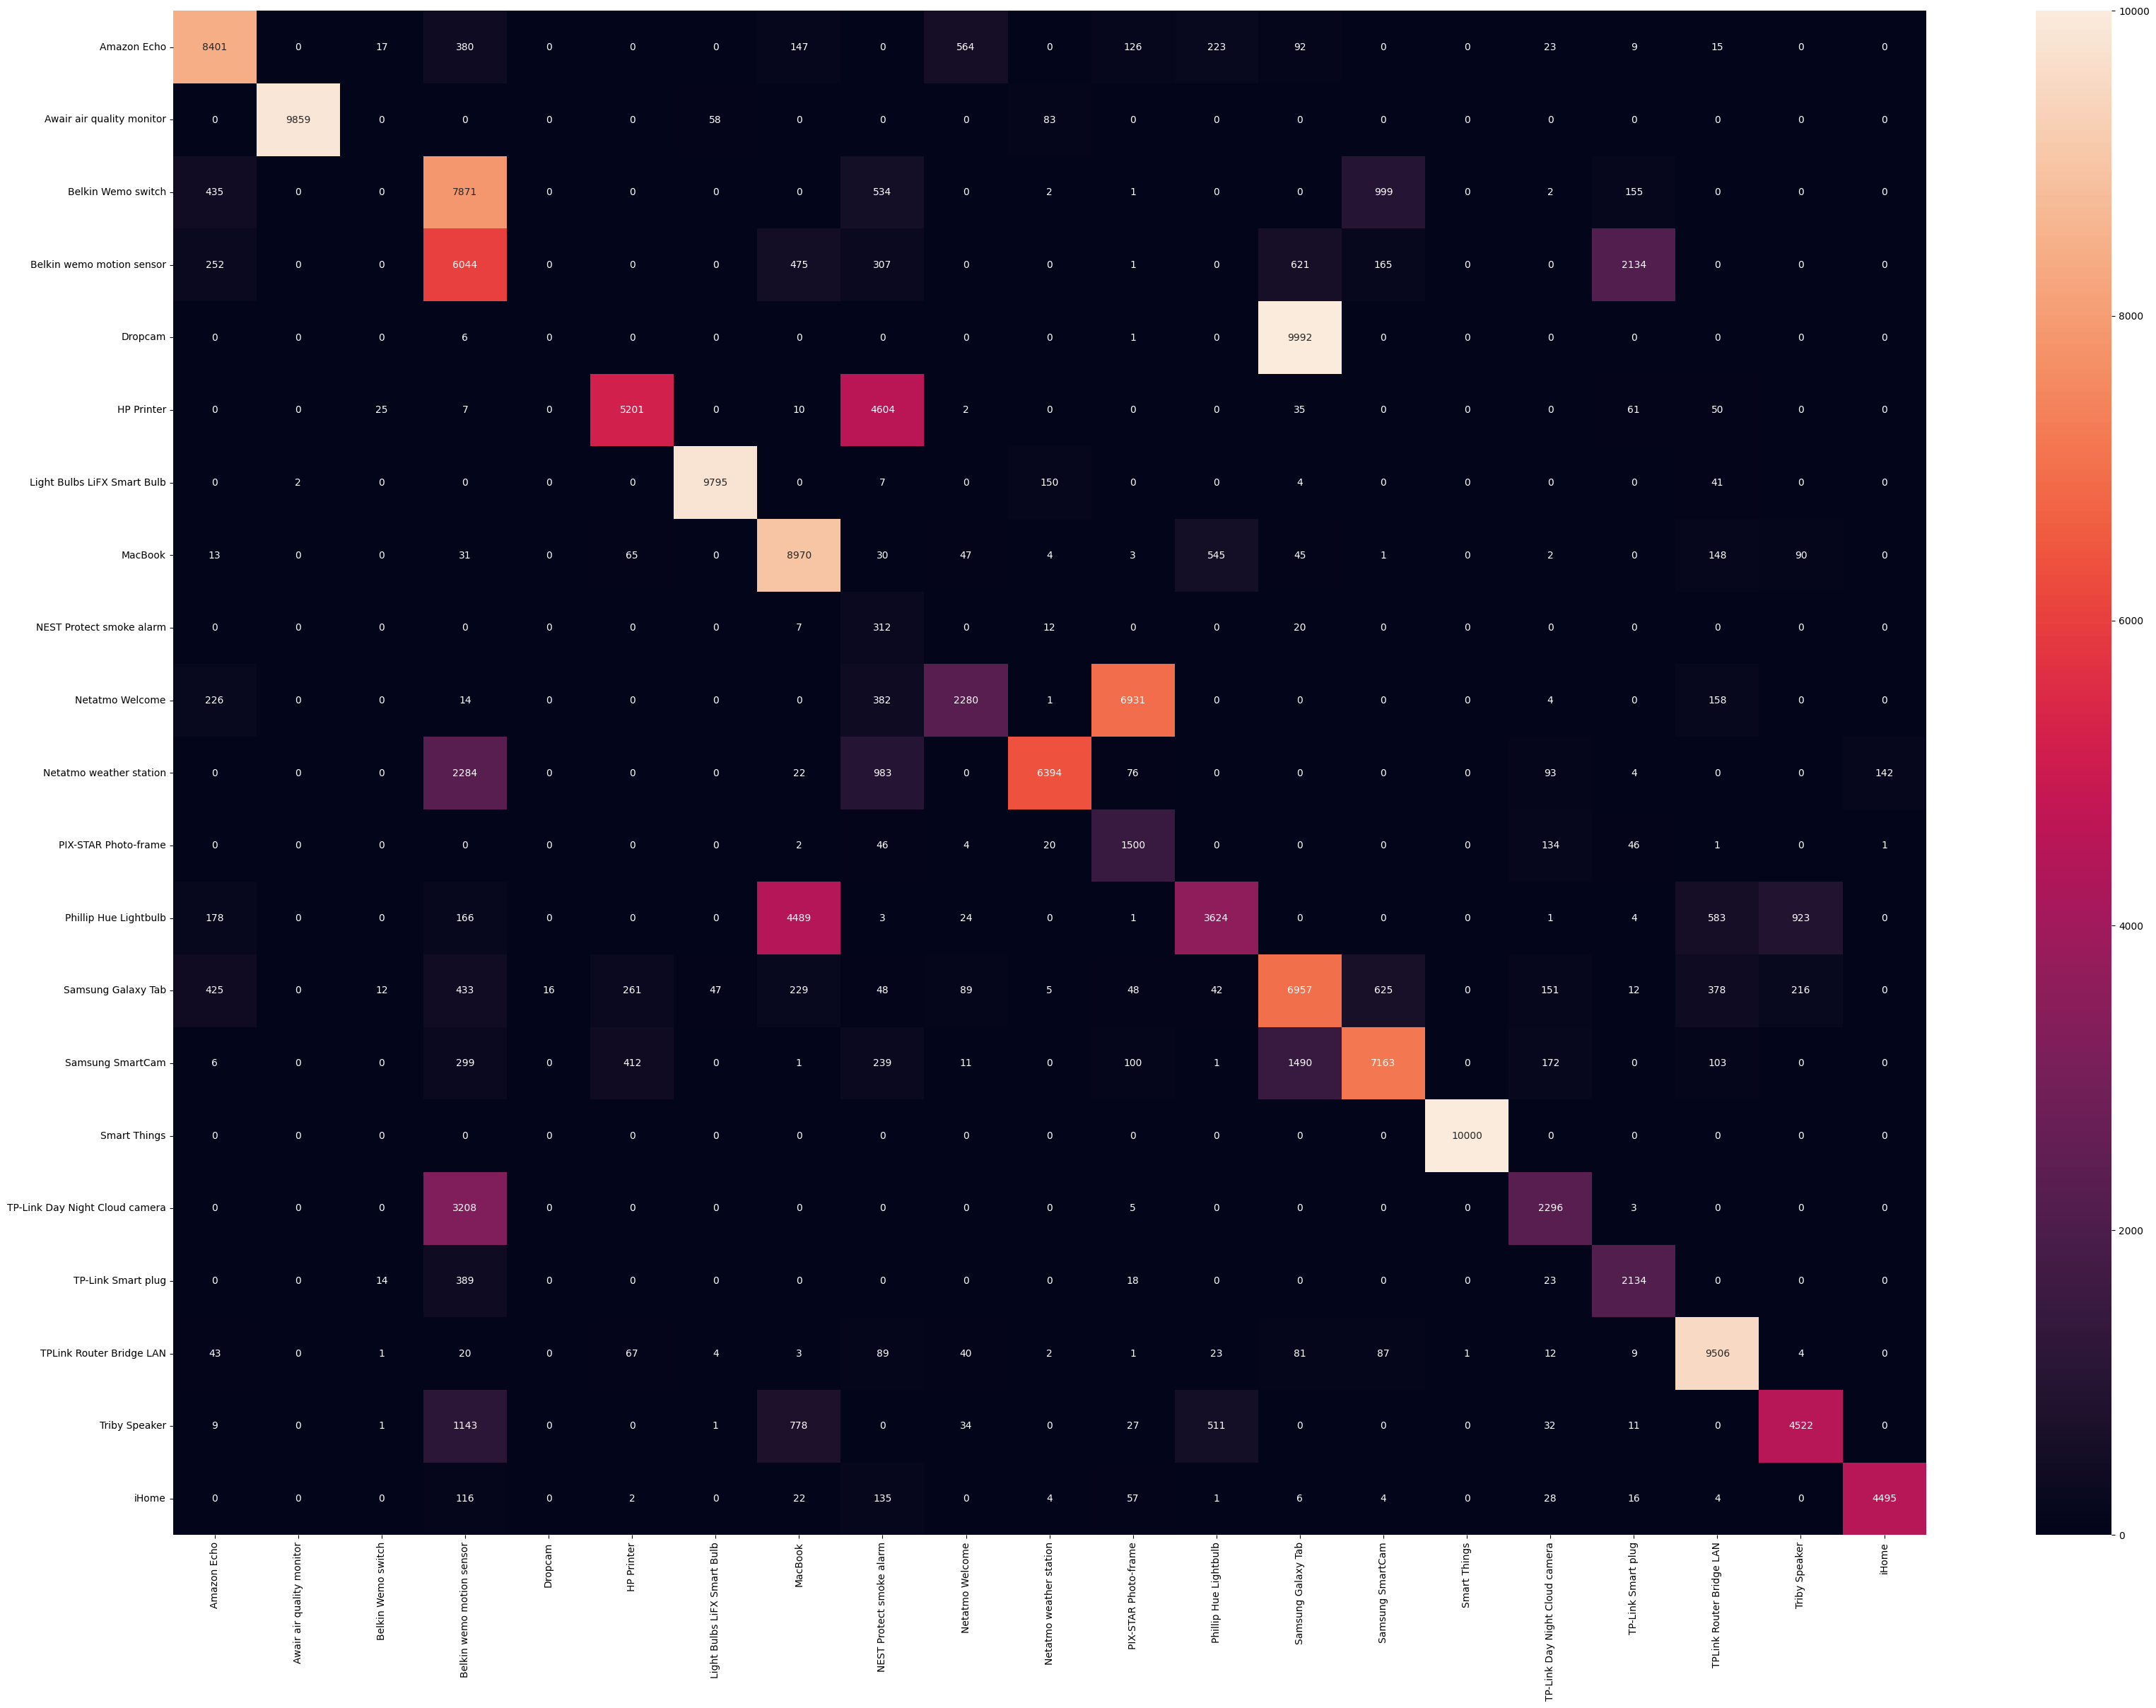

DI-S2-AD-S2
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.657    0.717   0.66   0.717  0.644  0.639      0    0.595     0.048          0
 1  results/other/1_1    1     2  DT    0.673    0.728   0.682  0.728  0.664  0.655      0    0.605     0.047          0
 2  results/other/1_1    2     3  DT    0.669    0.725   0.673  0.725  0.658  0.651      0    0.636     0.043          0
 3  results/other/1_1    3     4  DT    0.653    0.714   0.671  0.714  0.651  0.634      0    0.609     0.048          0
 4  results/other/1_1    4     5  DT    0.673    0.729   0.694  0.729  0.67   0.655      0    0.594     0.06           0
 5  results/other/1_1    5     6  DT    0.673    0.728   0.695  0.728  0.671  0.655      0    0.588     0.049          0
 6  results/other/1_

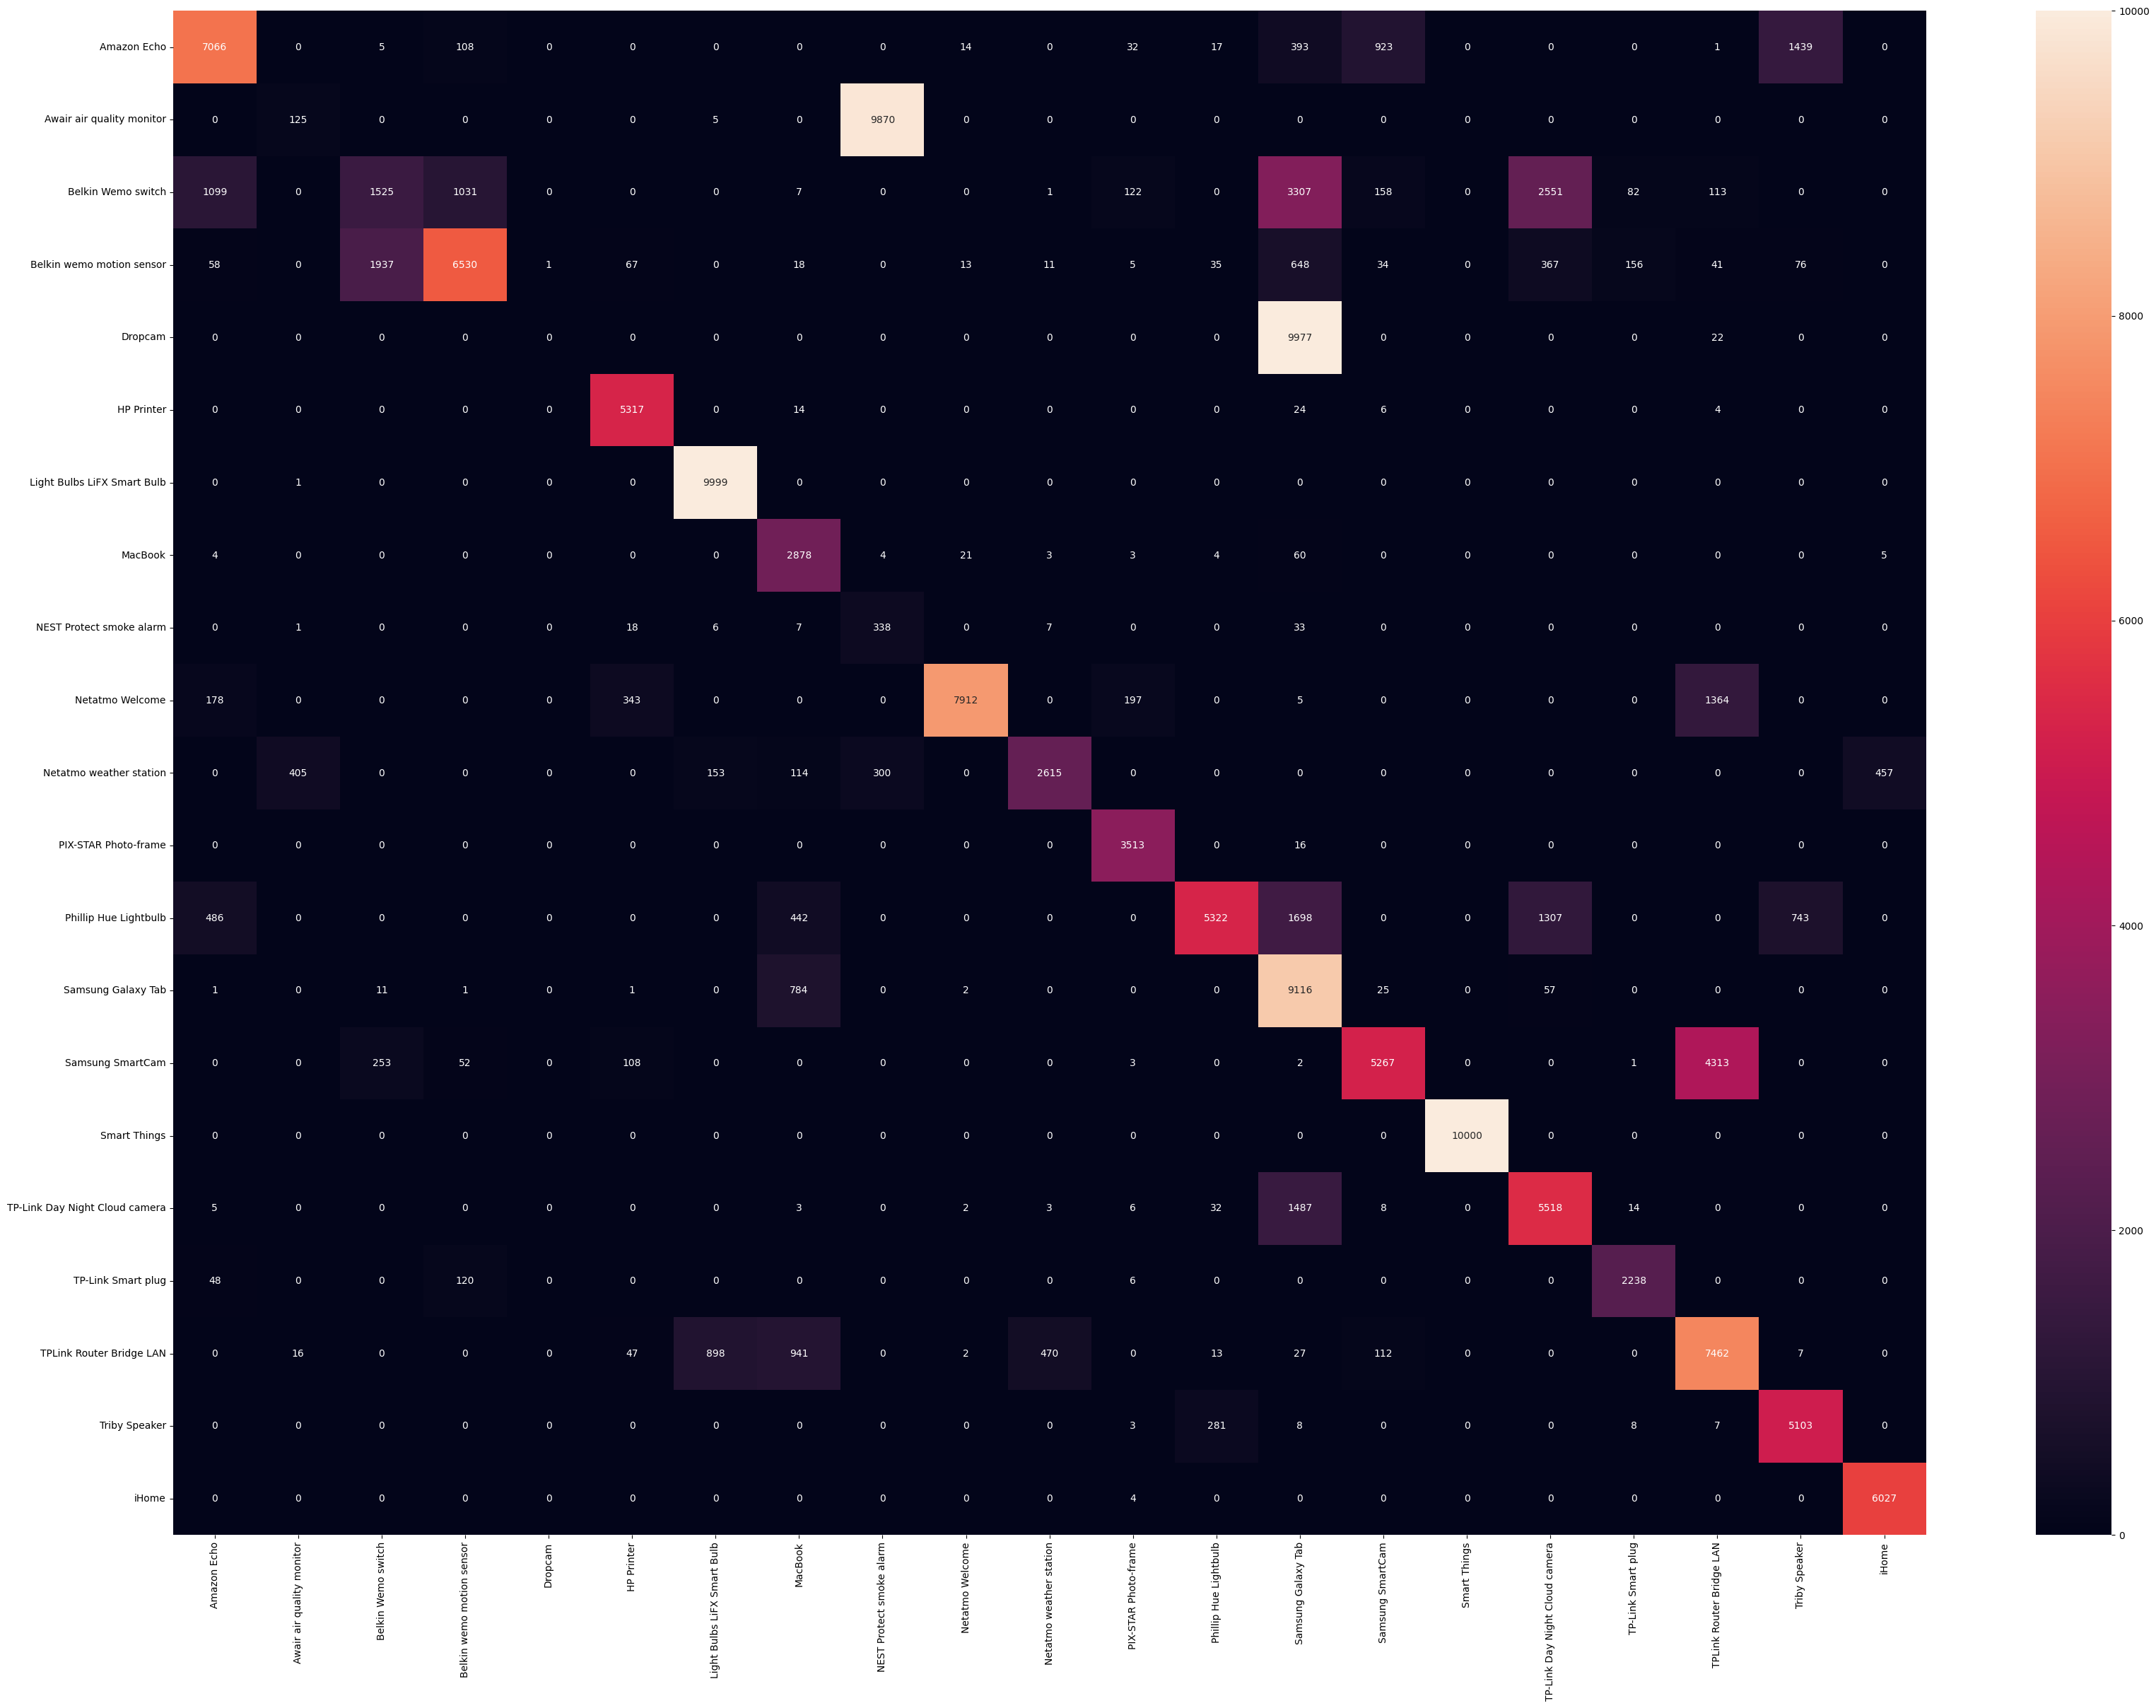

AD-S2-DI-S1
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.627    0.655   0.641  0.655  0.586  0.607      0    0.469     0.047          0
 1  results/other/1_1    1     2  DT    0.622    0.651   0.63   0.651  0.583  0.602      0    0.469     0.067          0
 2  results/other/1_1    2     3  DT    0.627    0.654   0.643  0.654  0.587  0.607      0    0.479     0.048          0
 3  results/other/1_1    3     4  DT    0.626    0.653   0.642  0.653  0.585  0.606      0    0.445     0.047          0
 4  results/other/1_1    4     5  DT    0.623    0.651   0.63   0.651  0.583  0.603      0    0.461     0.053          0
 5  results/other/1_1    5     6  DT    0.623    0.651   0.629  0.651  0.583  0.603      0    0.454     0.047          0
 6  results/other/1_

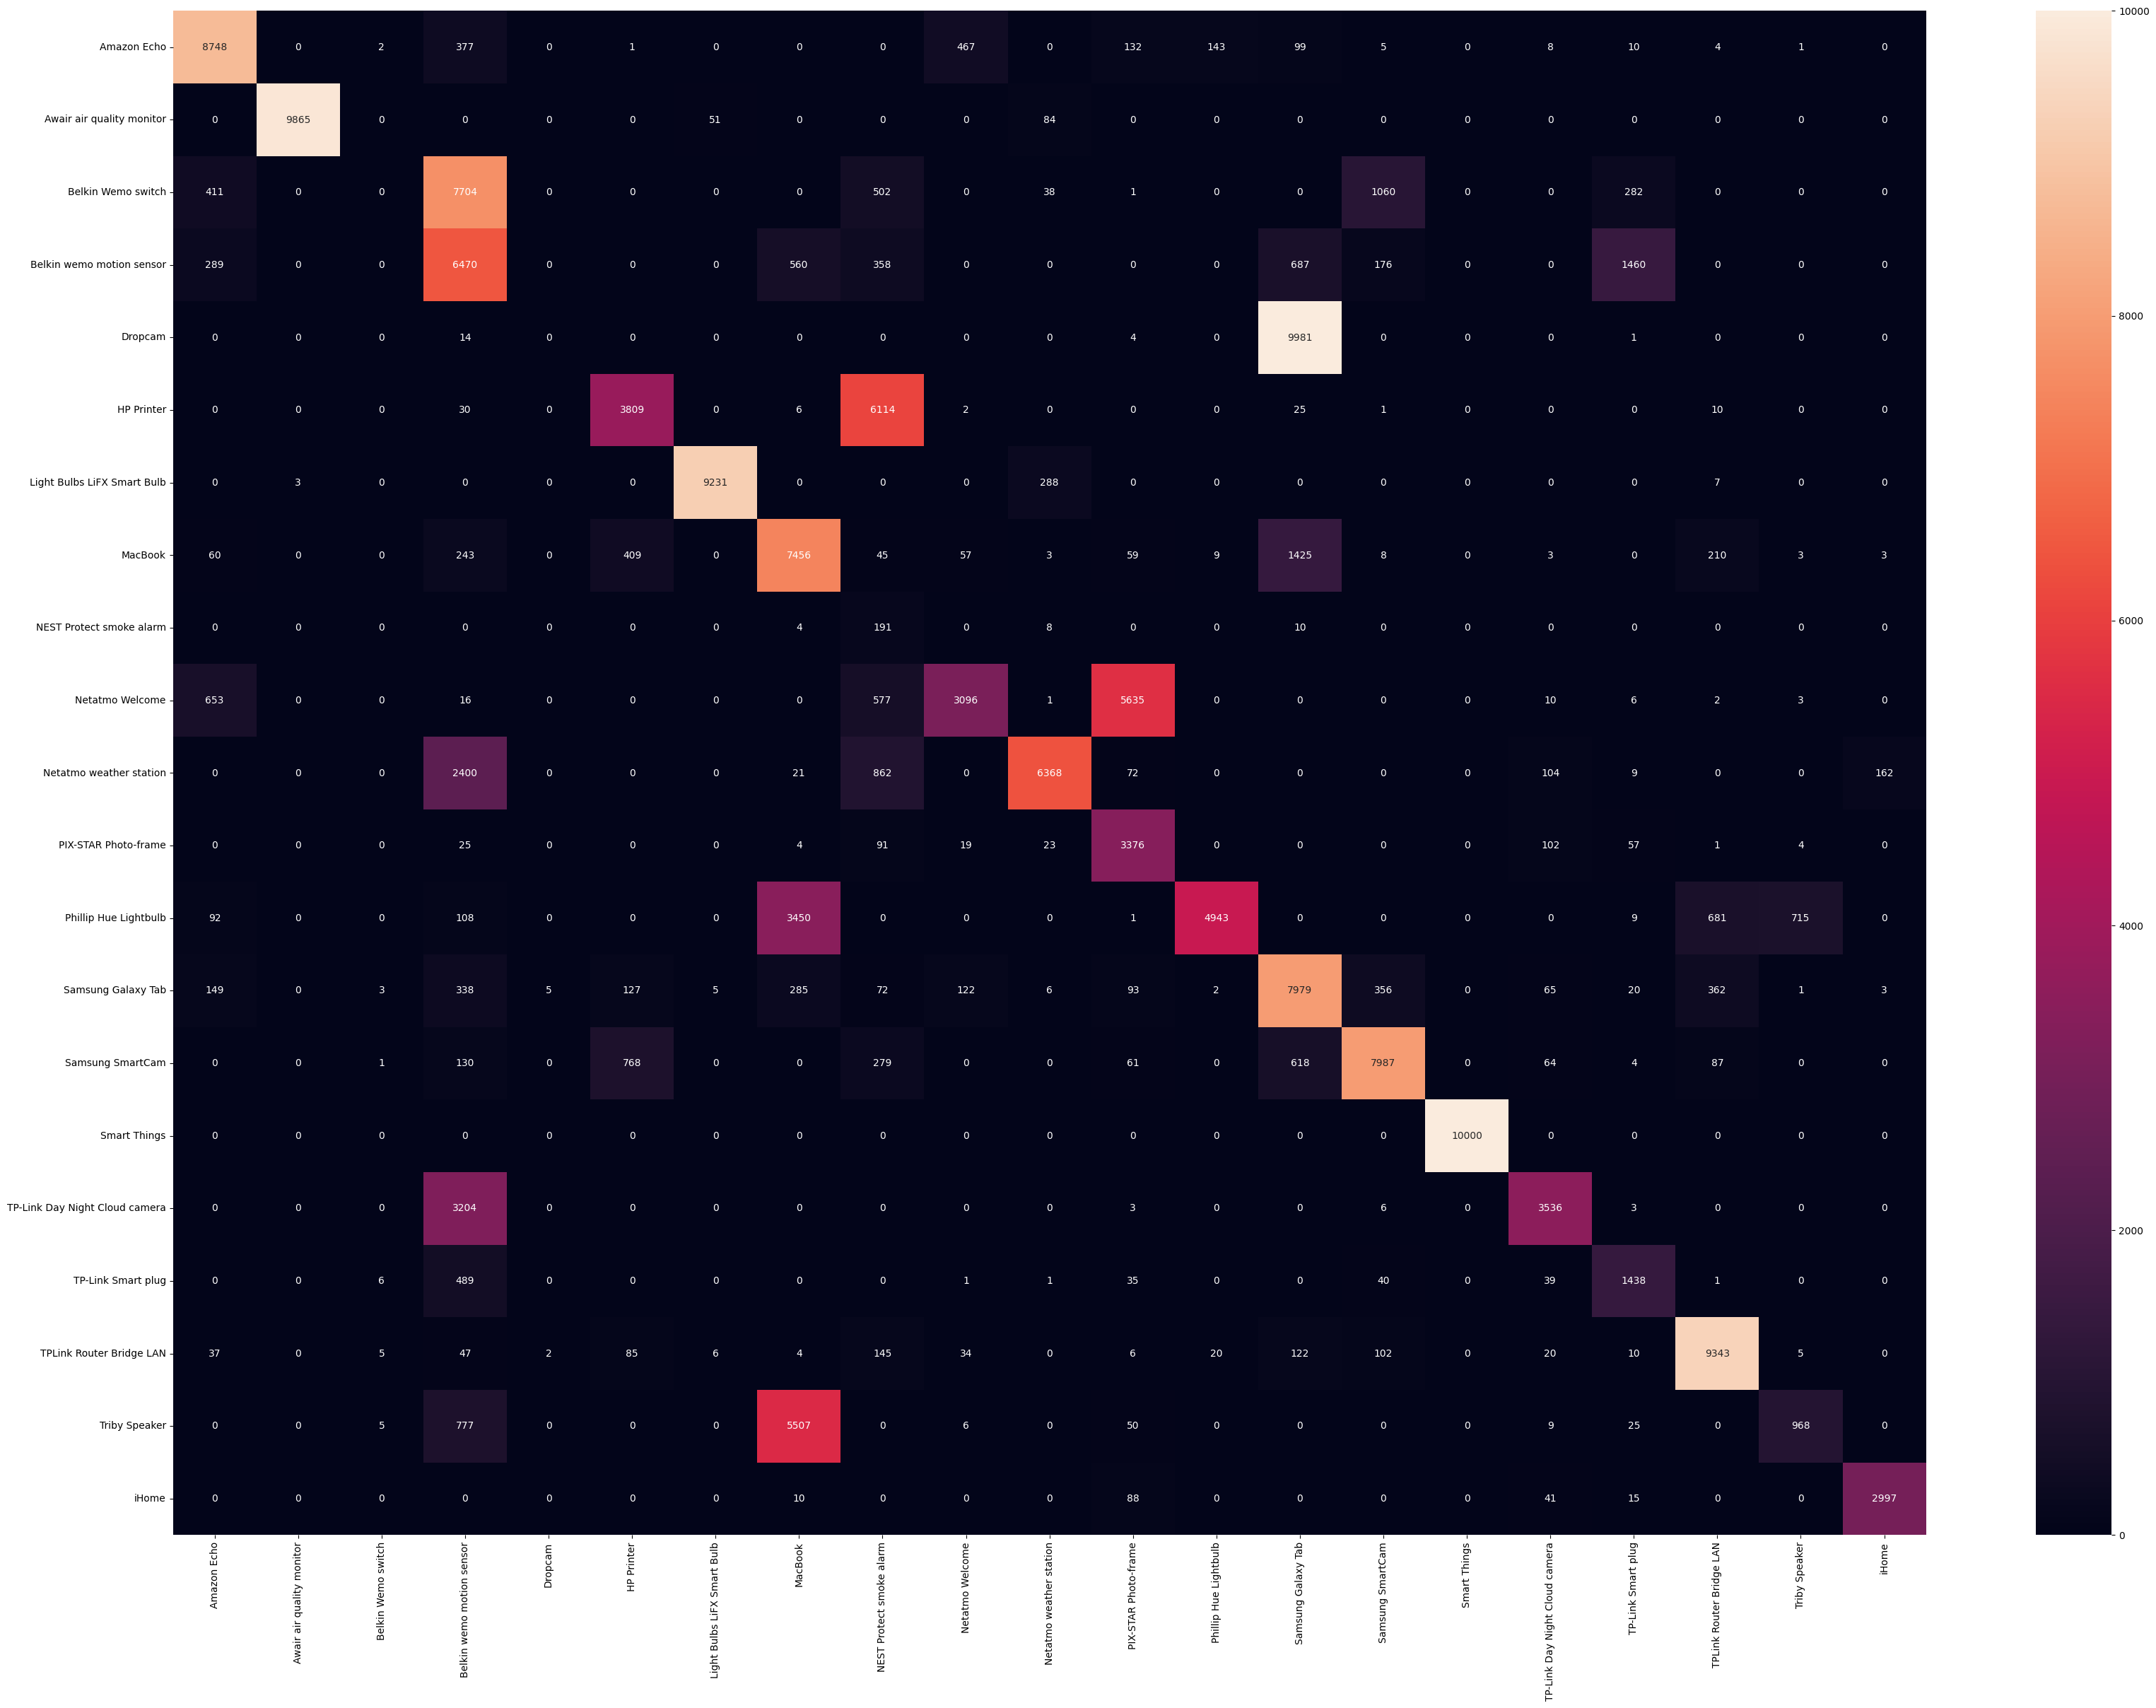

DI-S1-AD-S2
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.661    0.715   0.706  0.715  0.652  0.643      0    0.557     0.048          0
 1  results/other/1_1    1     2  DT    0.668    0.72    0.711  0.72   0.652  0.651      0    0.544     0.049          0
 2  results/other/1_1    2     3  DT    0.669    0.721   0.681  0.721  0.657  0.651      0    0.532     0.047          0
 3  results/other/1_1    3     4  DT    0.66     0.714   0.677  0.714  0.652  0.641      0    0.55      0.05           0
 4  results/other/1_1    4     5  DT    0.67     0.721   0.687  0.721  0.66   0.652      0    0.549     0.048          0
 5  results/other/1_1    5     6  DT    0.66     0.714   0.686  0.714  0.652  0.642      0    0.515     0.048          0
 6  results/other/1_

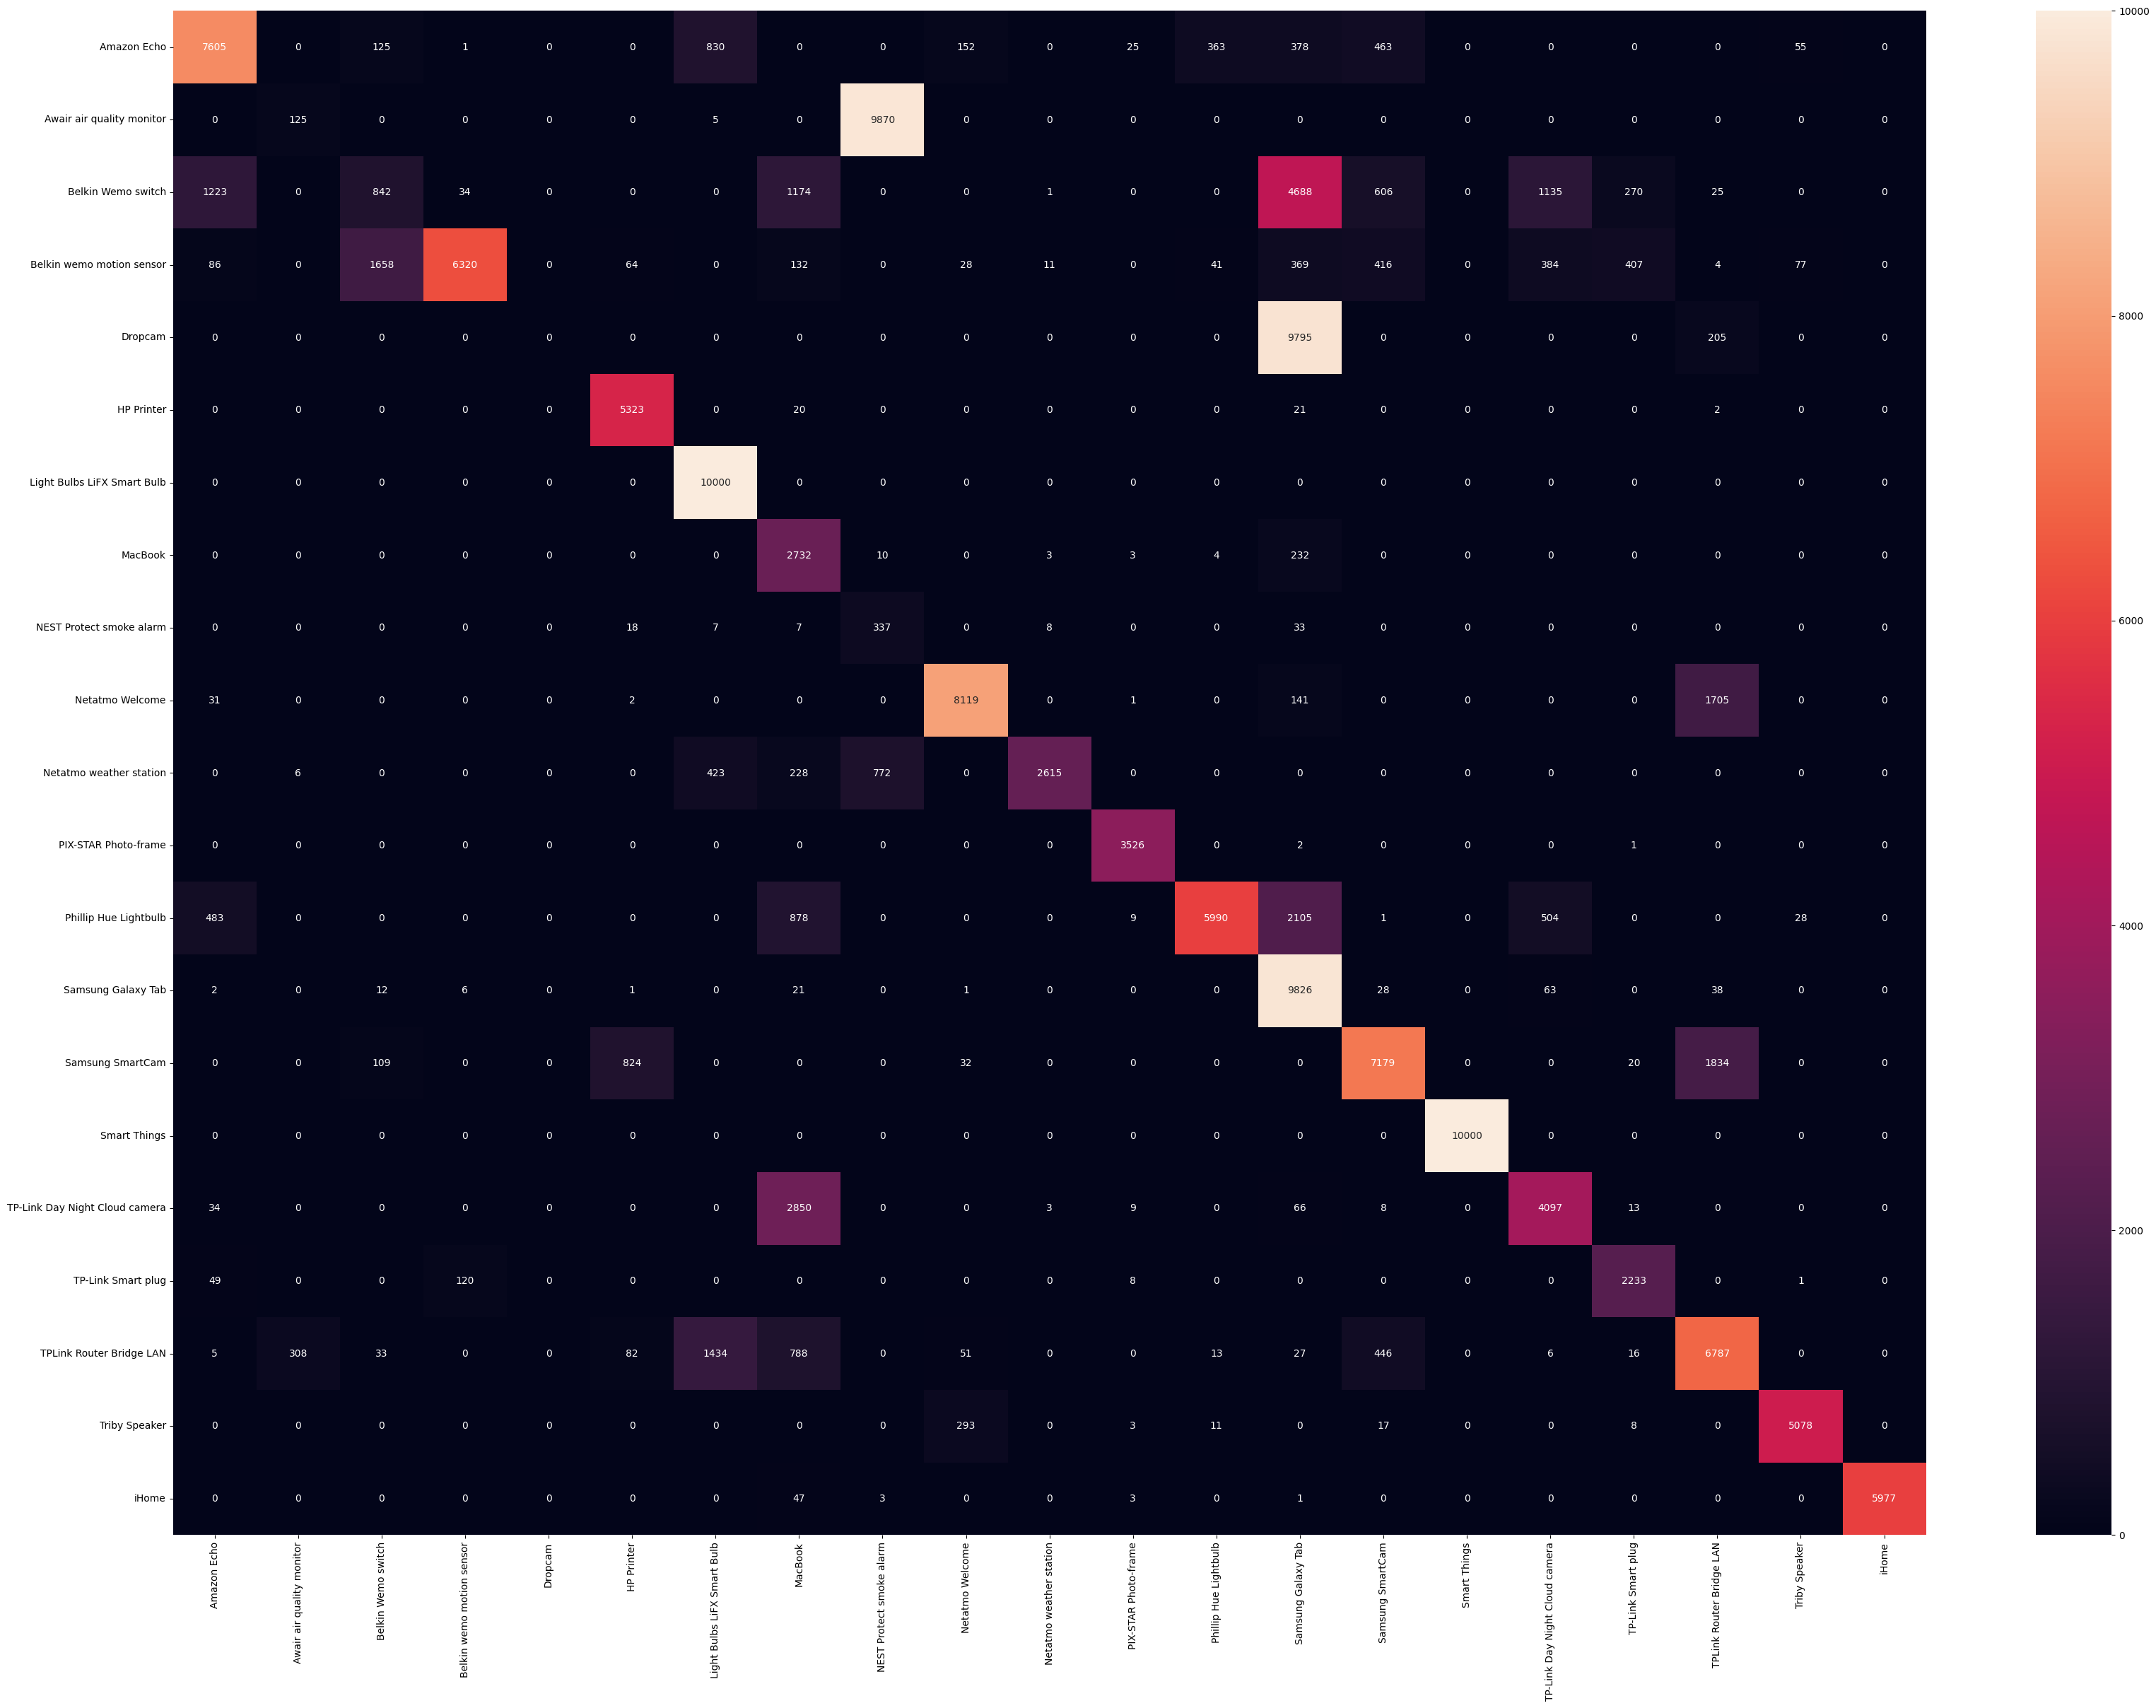

In [19]:
say=0
dataset="./results/other/1/"
folder(dataset)
for ii in file_list:
        say+=1
        train=file_list[ii][0]
        test=file_list[ii][1]
        mixed=False
        step=1
        sayac=1
        output_csv=f"{dataset}/@{file_list[ii][0][8:-4]}@{file_list[ii][1][8:-4]}.csv"
        print(f"{file_list[ii][0][8:-4]}-{file_list[ii][1][8:-4]}")
        target_names=target_name(test)
        ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


AD-S1-DI-S1
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.804    0.82    0.858  0.82   0.787  0.793      0    0.565     0.06       3.072
 1  results/other/13_13    1     2  DT    0.801    0.817   0.858  0.817  0.786  0.789      0    0.578     0.064      2.98
 2  results/other/13_13    2     3  DT    0.804    0.82    0.85   0.82   0.789  0.793      0    0.585     0.04       2.954
 3  results/other/13_13    3     4  DT    0.805    0.821   0.865  0.821  0.79   0.793      0    0.581     0.045      2.927
 4  results/other/13_13    4     5  DT    0.805    0.821   0.863  0.821  0.79   0.794      0    0.584     0.055      2.994
 5  results/other/13_13    5     6  DT    0.8      0.817   0.863  0.817  0.787  0.788      0    0.571     0.046      2.964
 6  r

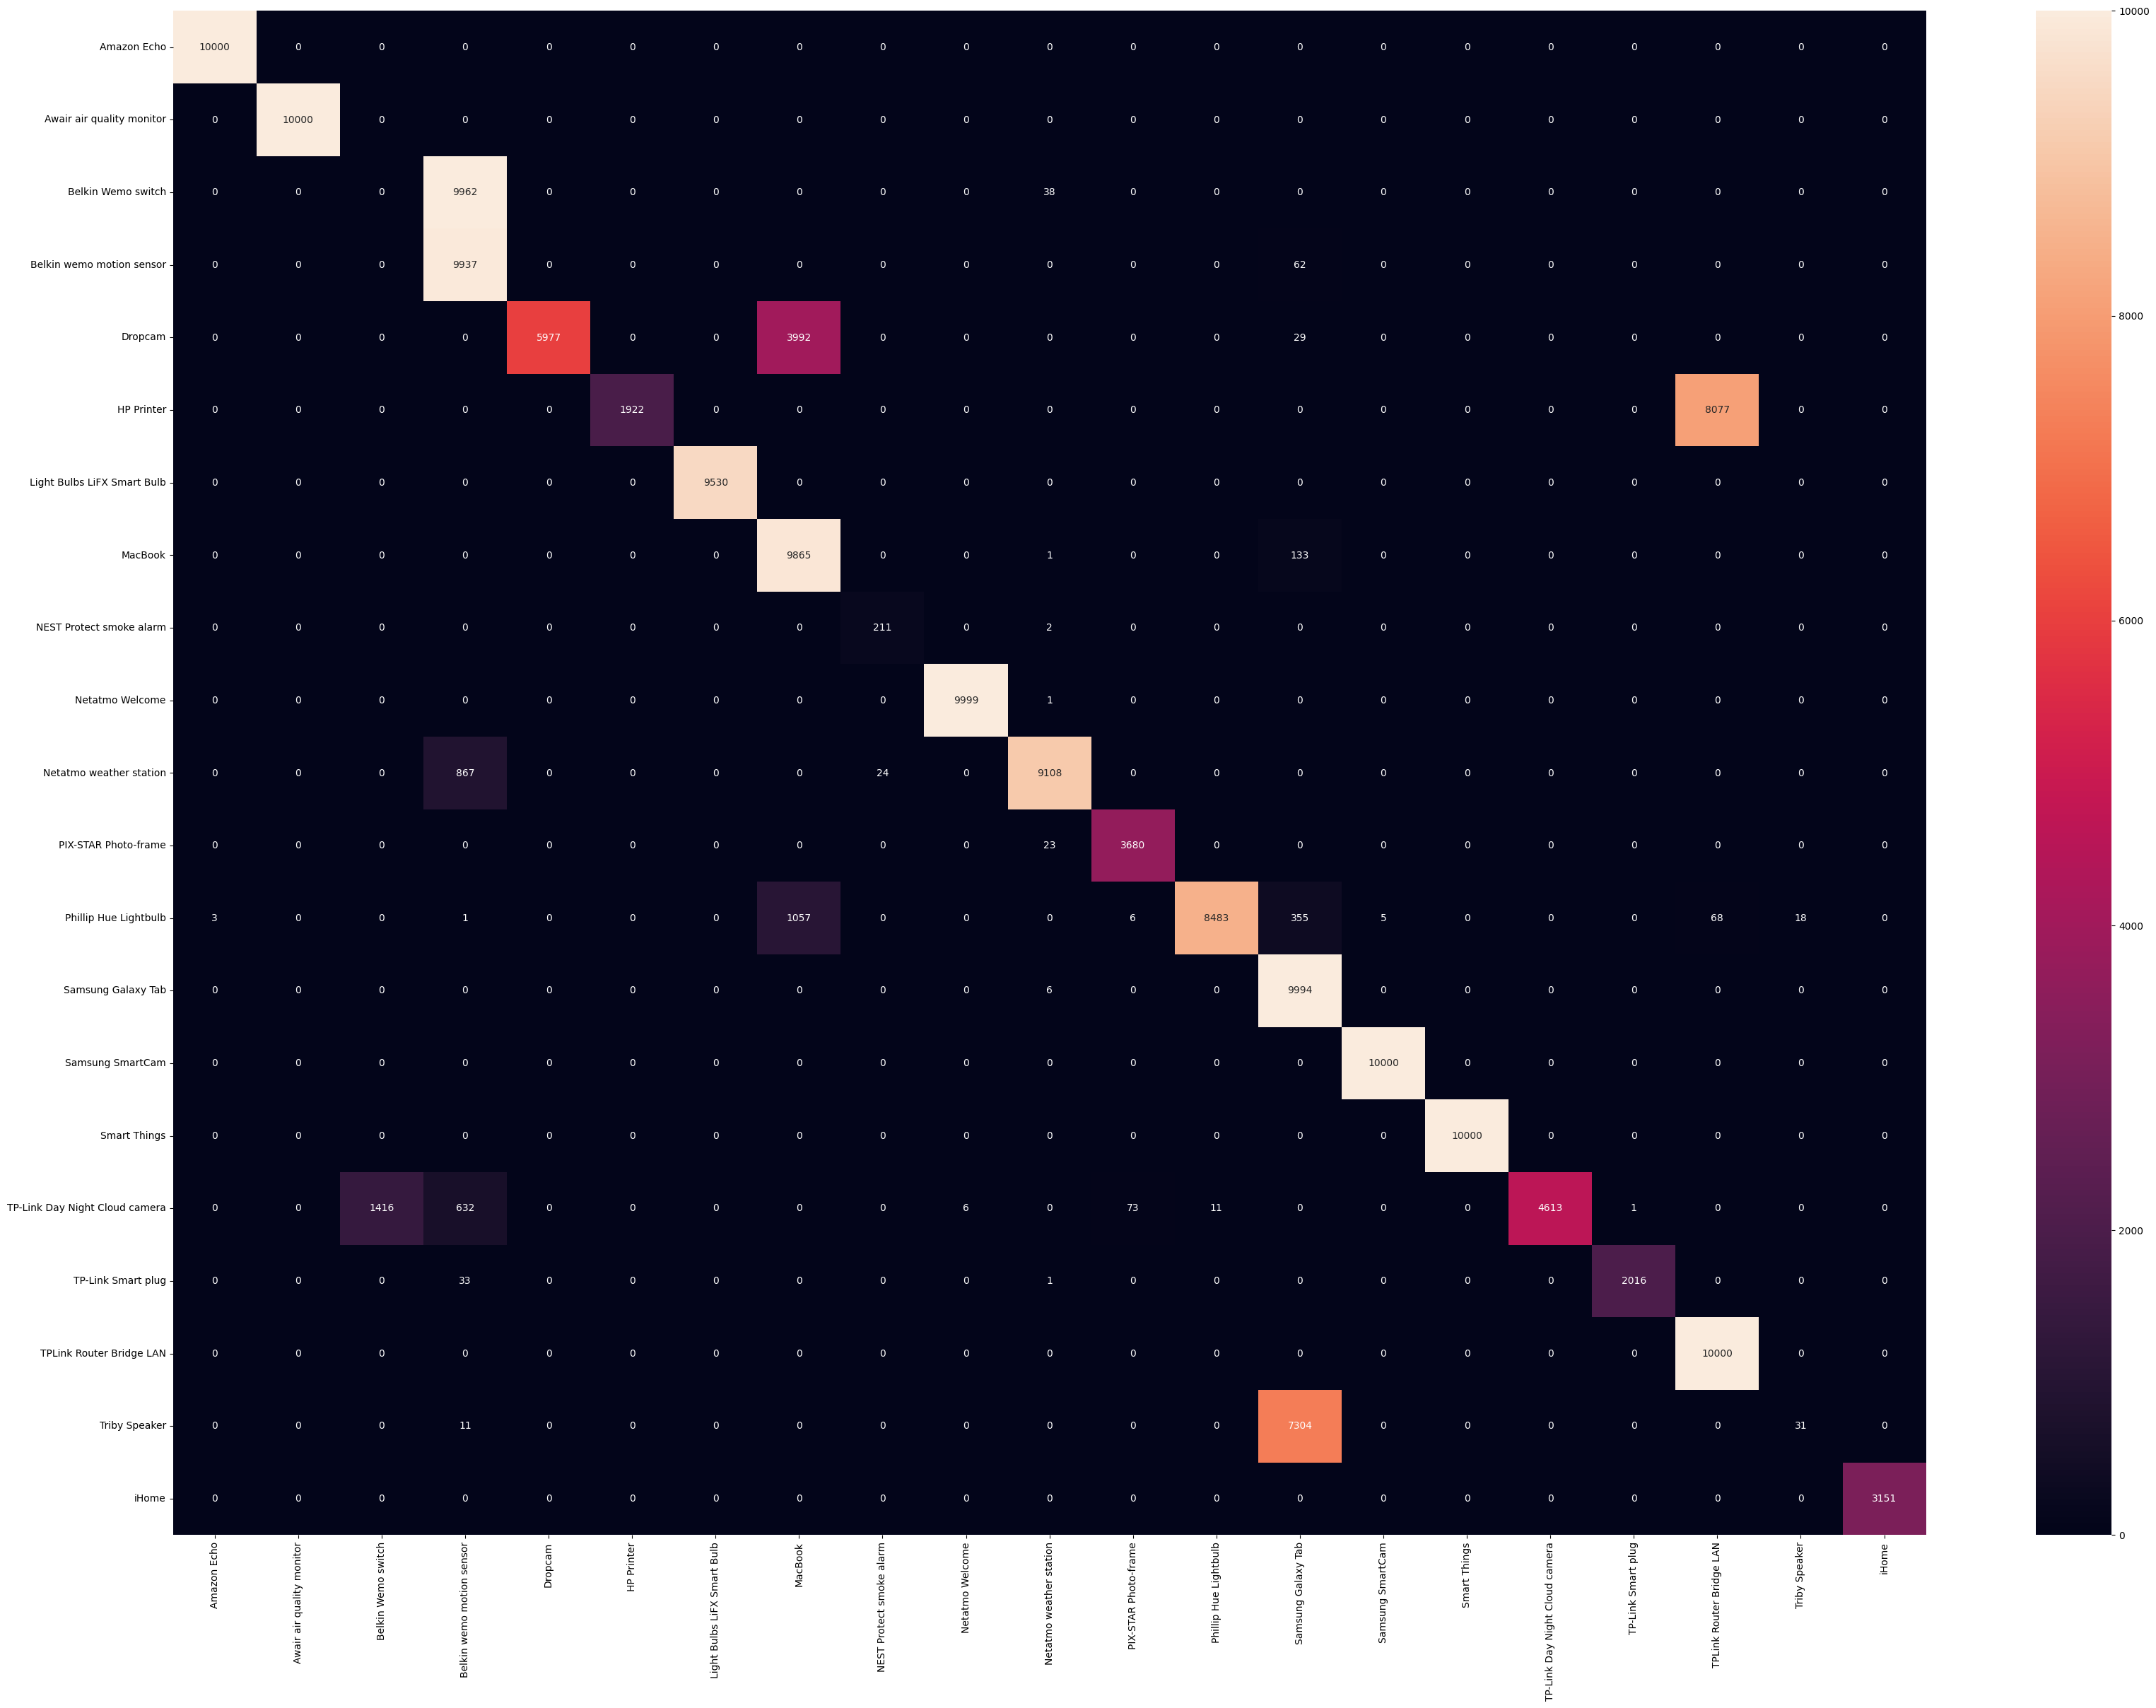

DI-S1-AD-S1
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.727    0.783   0.724  0.783  0.699  0.713      0    0.522     0.059      2.891
 1  results/other/13_13    1     2  DT    0.714    0.775   0.726  0.775  0.687  0.7        0    0.547     0.055      2.775
 2  results/other/13_13    2     3  DT    0.712    0.772   0.726  0.772  0.685  0.699      0    0.535     0.063      2.862
 3  results/other/13_13    3     4  DT    0.726    0.783   0.724  0.783  0.698  0.712      0    0.566     0.047      2.939
 4  results/other/13_13    4     5  DT    0.726    0.783   0.723  0.783  0.698  0.712      0    0.566     0.047      2.94
 5  results/other/13_13    5     6  DT    0.727    0.784   0.724  0.784  0.699  0.712      0    0.534     0.063      2.925
 6  r

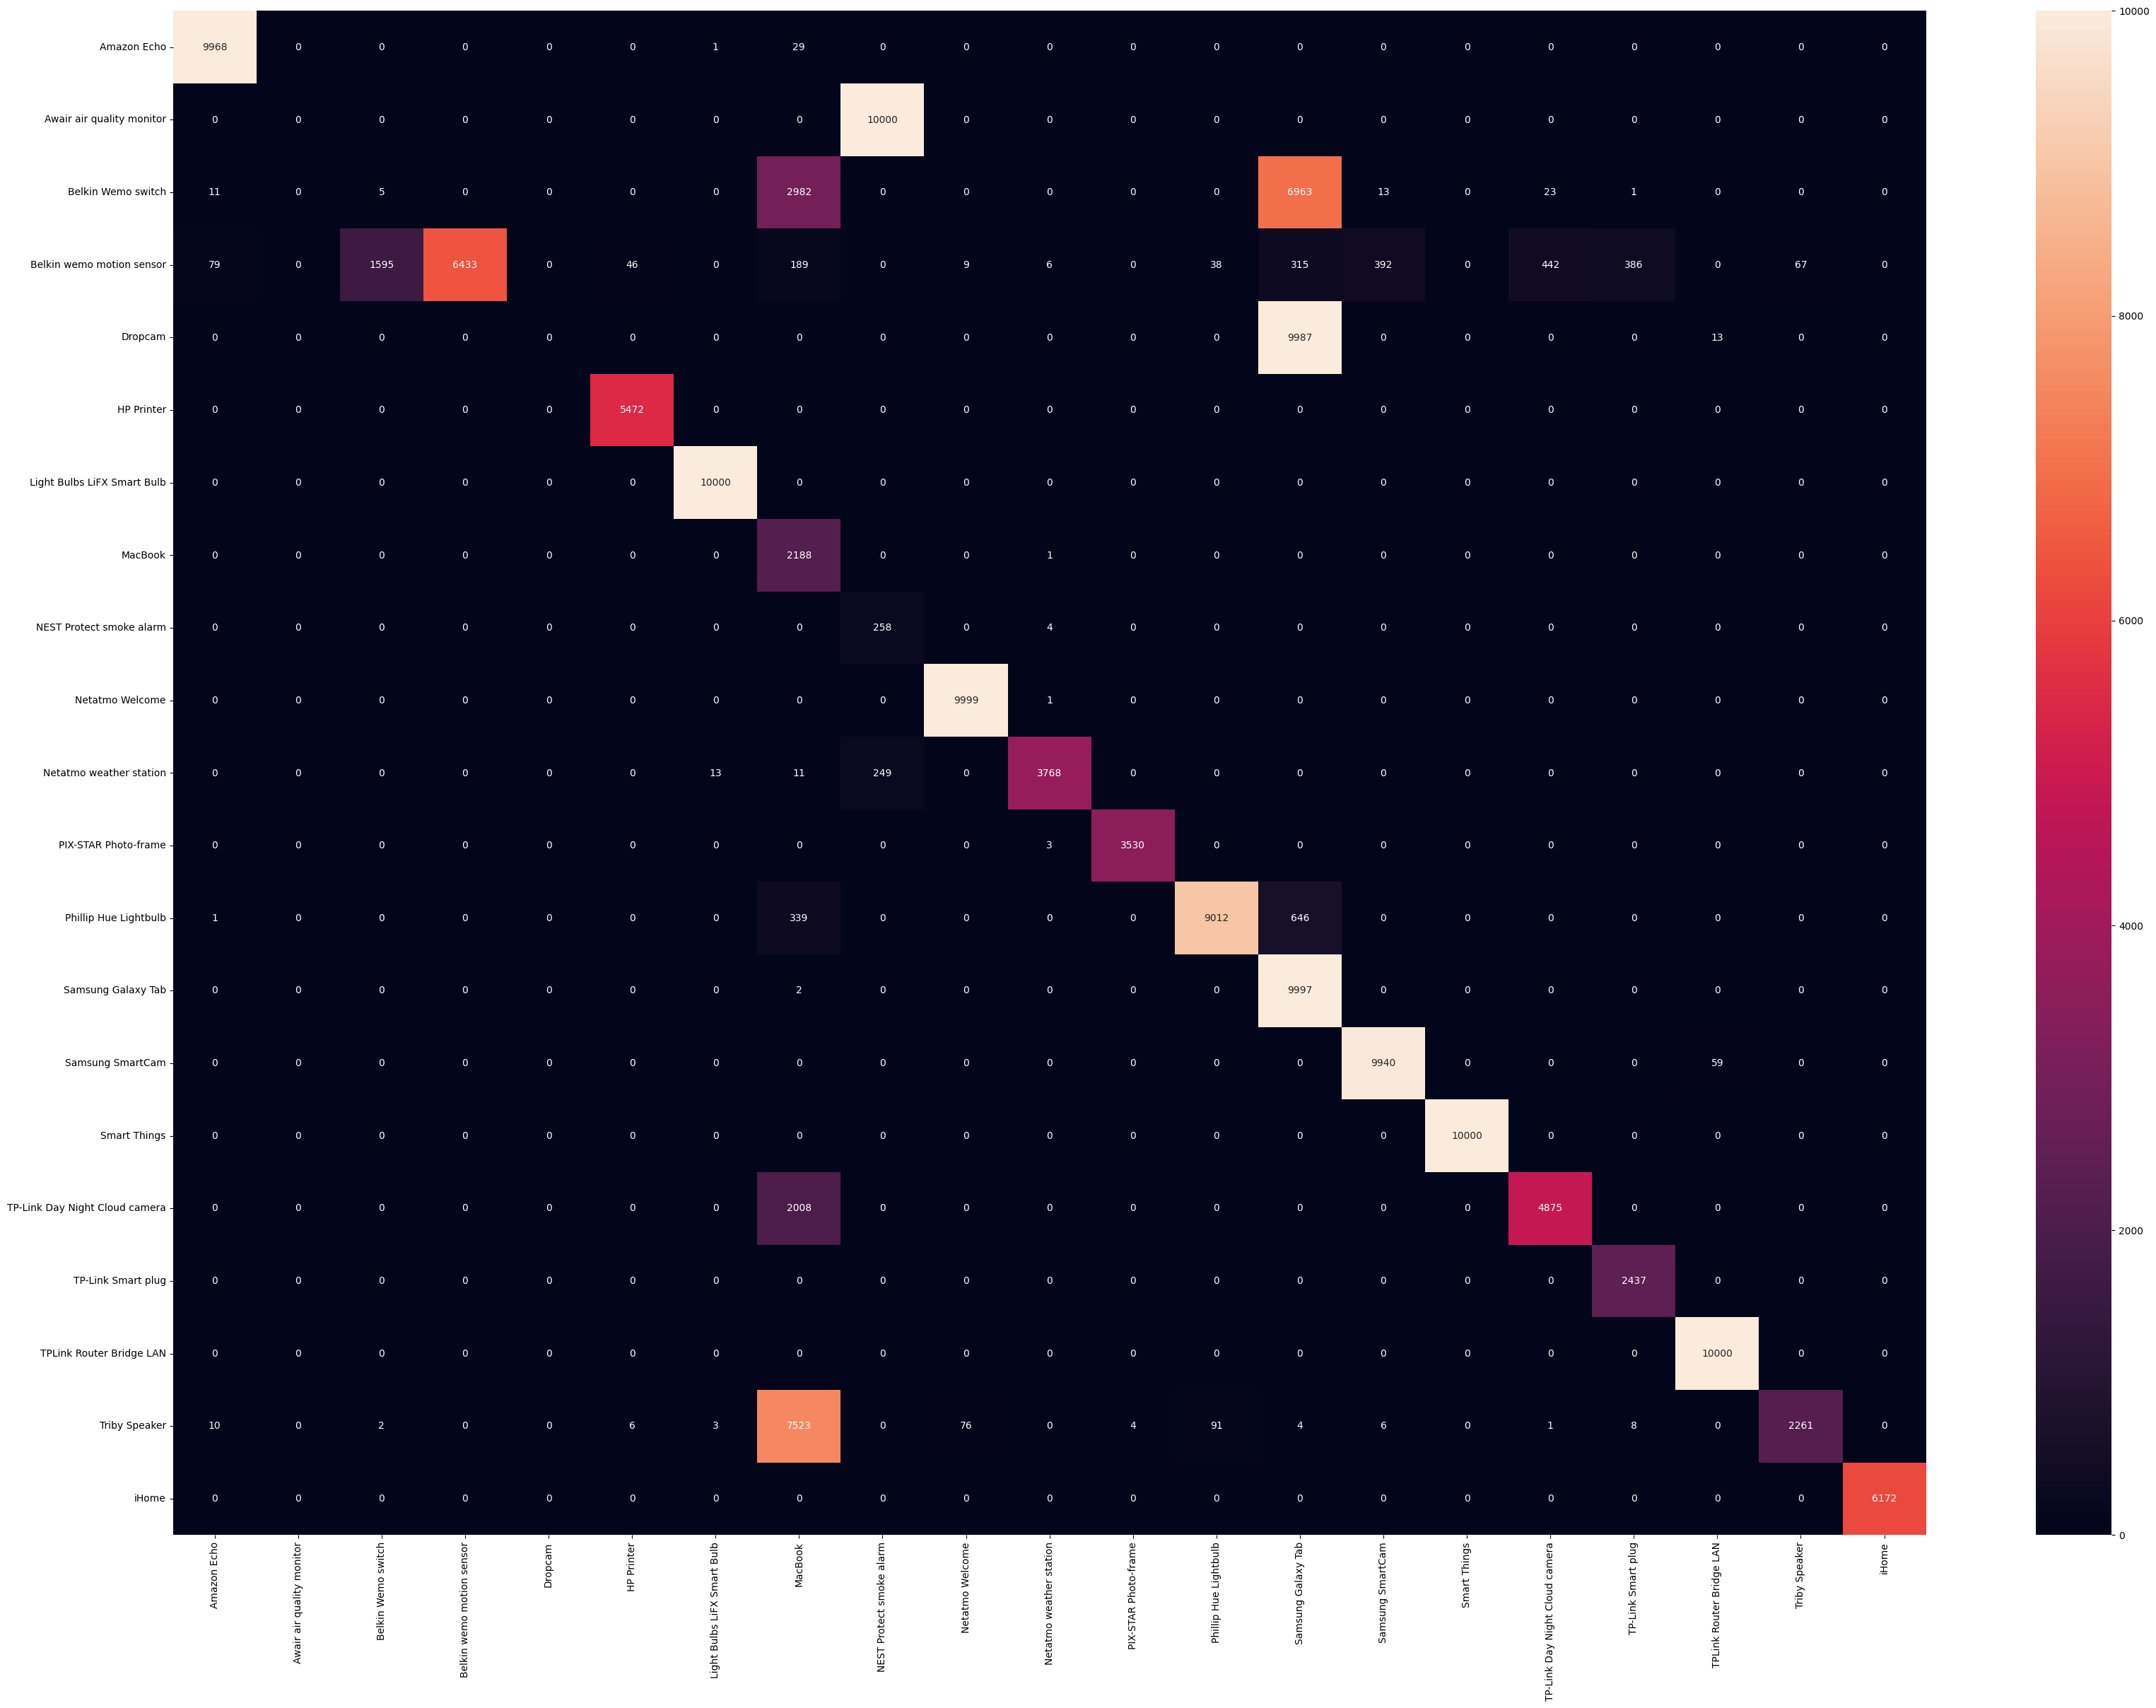

AD-S1-DI-S2
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.831    0.852   0.87   0.852  0.831  0.821      0    0.608     0.049      2.935
 1  results/other/13_13    1     2  DT    0.827    0.849   0.87   0.849  0.828  0.817      0    0.536     0.051      2.839
 2  results/other/13_13    2     3  DT    0.829    0.85    0.872  0.85   0.831  0.819      0    0.496     0.05       2.829
 3  results/other/13_13    3     4  DT    0.831    0.852   0.872  0.852  0.834  0.821      0    0.562     0.053      2.772
 4  results/other/13_13    4     5  DT    0.832    0.853   0.875  0.853  0.836  0.823      0    0.522     0.058      2.802
 5  results/other/13_13    5     6  DT    0.832    0.852   0.871  0.852  0.834  0.822      0    0.562     0.066      2.699
 6  

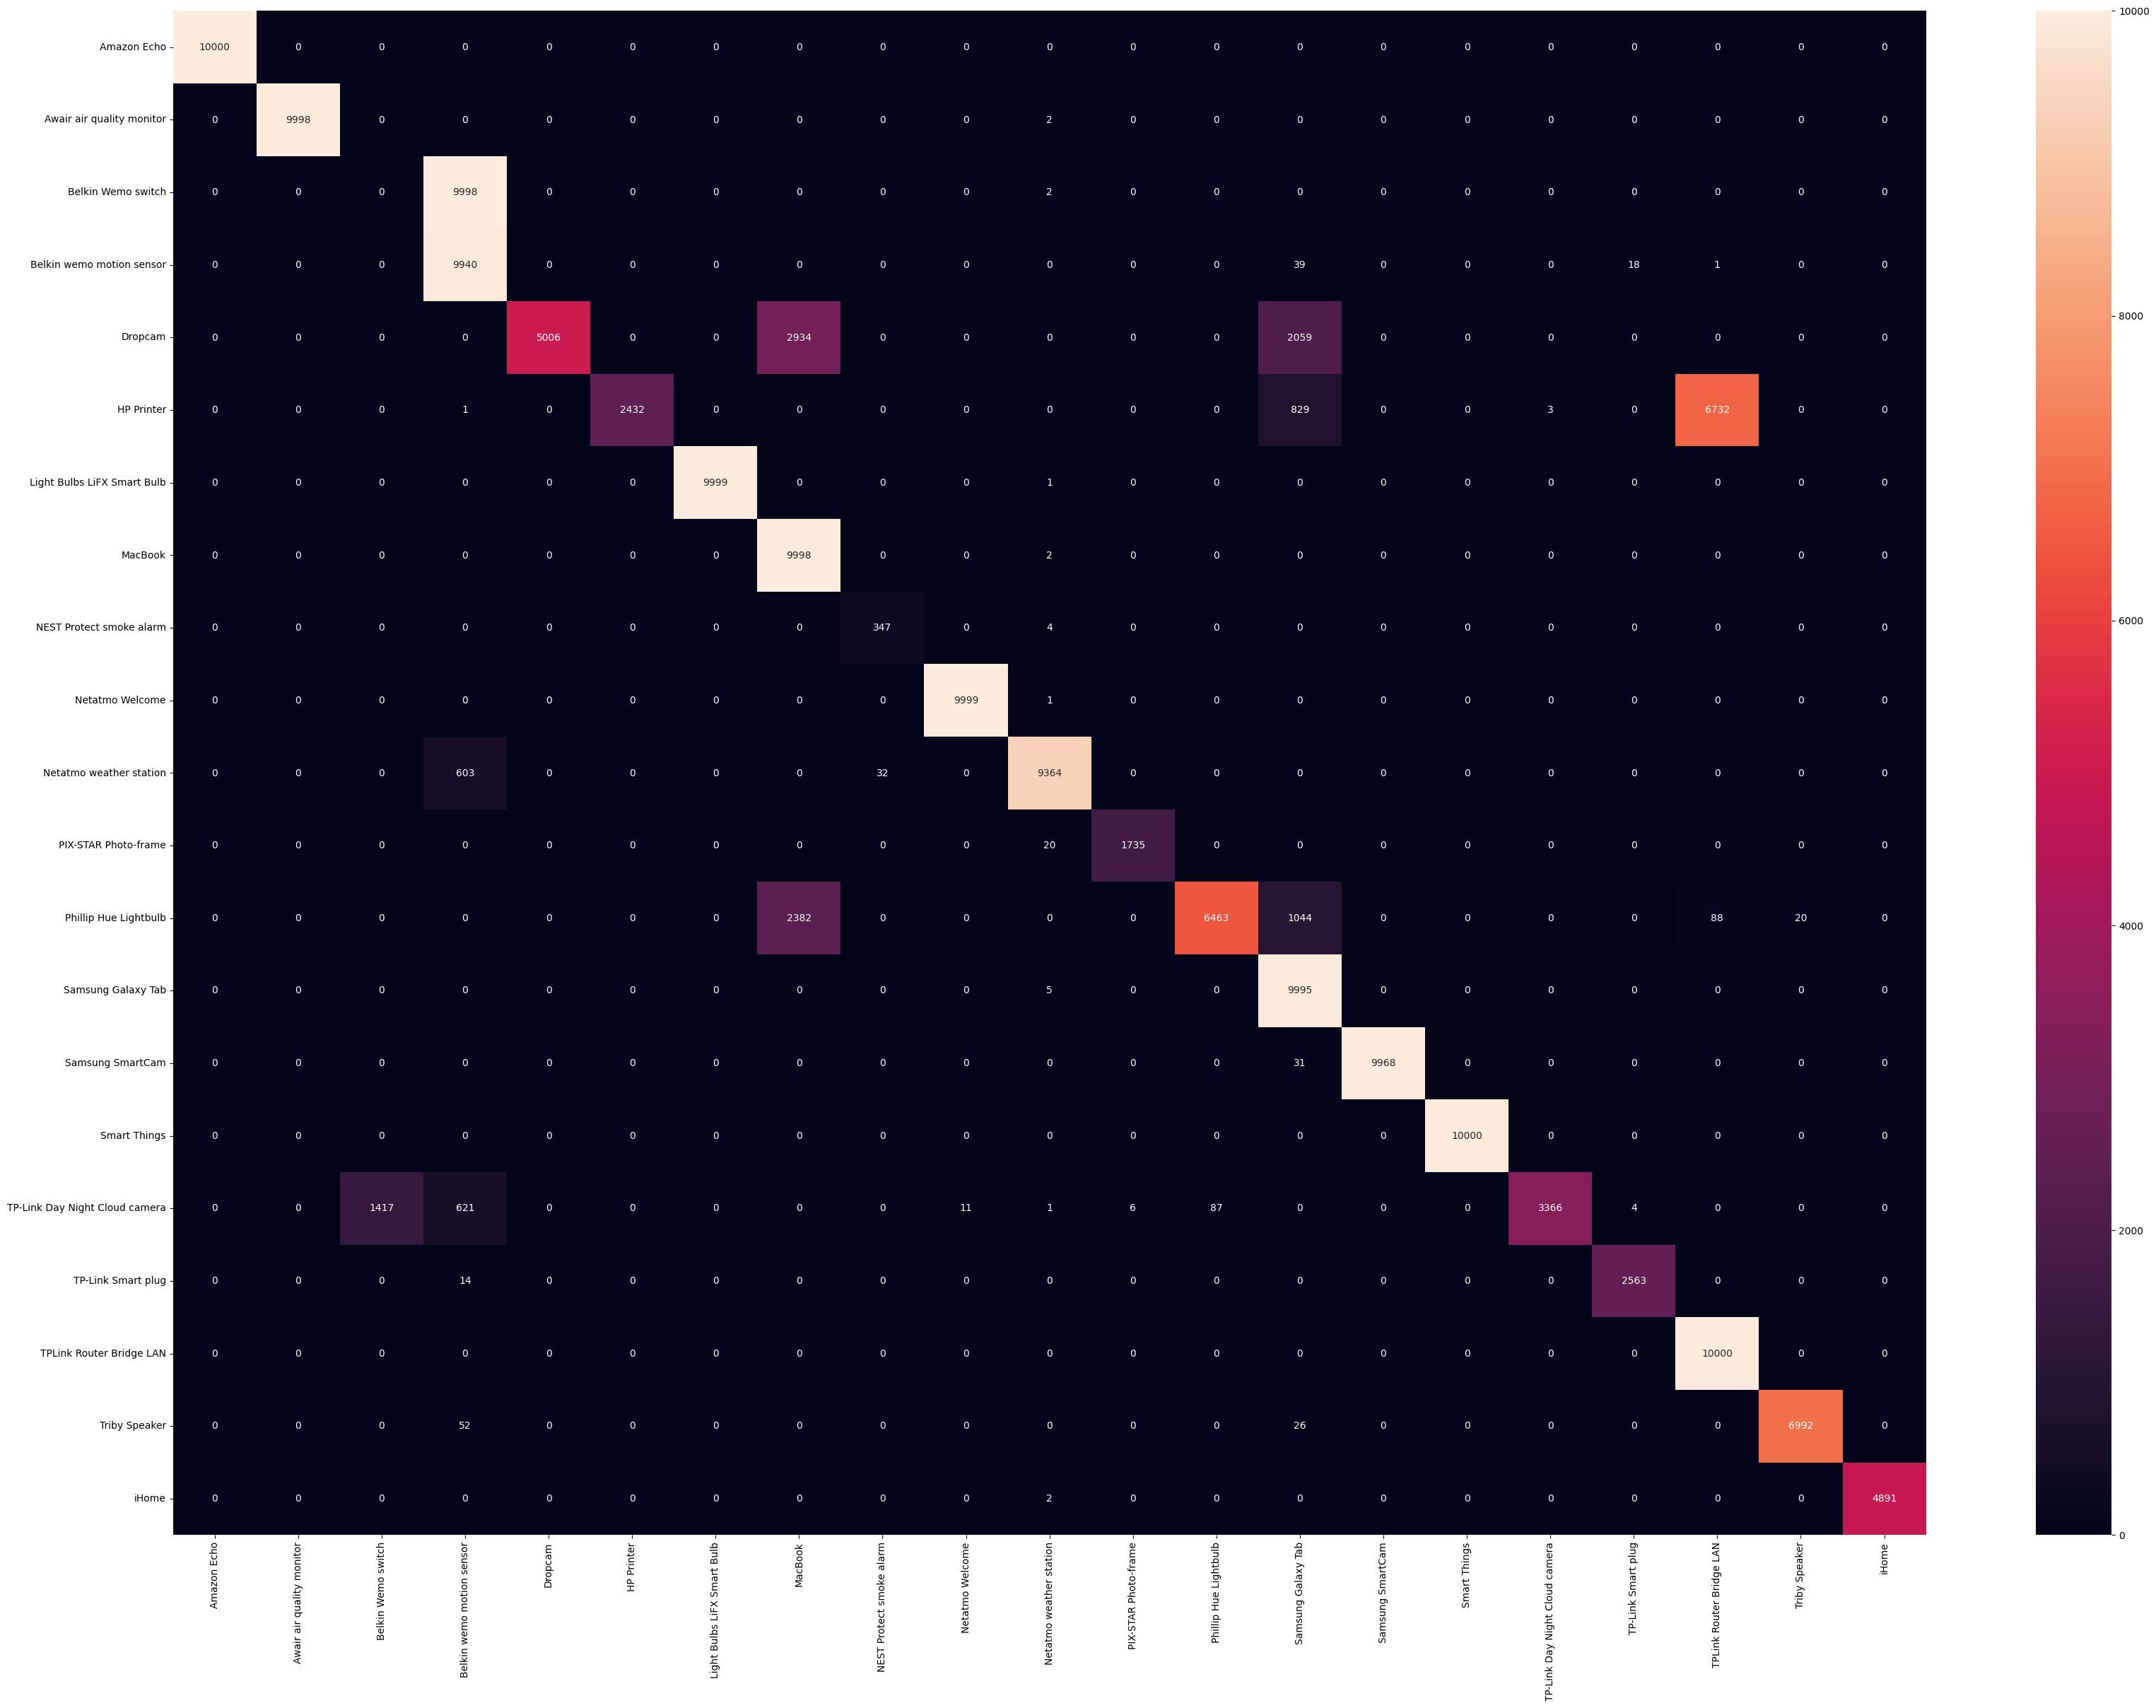

DI-S2-AD-S1
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.747    0.795   0.75   0.795  0.707  0.734      0    0.562     0.049      2.63
 1  results/other/13_13    1     2  DT    0.746    0.804   0.771  0.804  0.722  0.733      0    0.571     0.051      2.736
 2  results/other/13_13    2     3  DT    0.747    0.805   0.77   0.805  0.722  0.734      0    0.526     0.052      2.574
 3  results/other/13_13    3     4  DT    0.712    0.768   0.716  0.768  0.687  0.696      0    0.569     0.046      2.656
 4  results/other/13_13    4     5  DT    0.719    0.784   0.72   0.784  0.698  0.704      0    0.551     0.045      2.671
 5  results/other/13_13    5     6  DT    0.714    0.78    0.718  0.78   0.694  0.699      0    0.536     0.046      2.649
 6  r

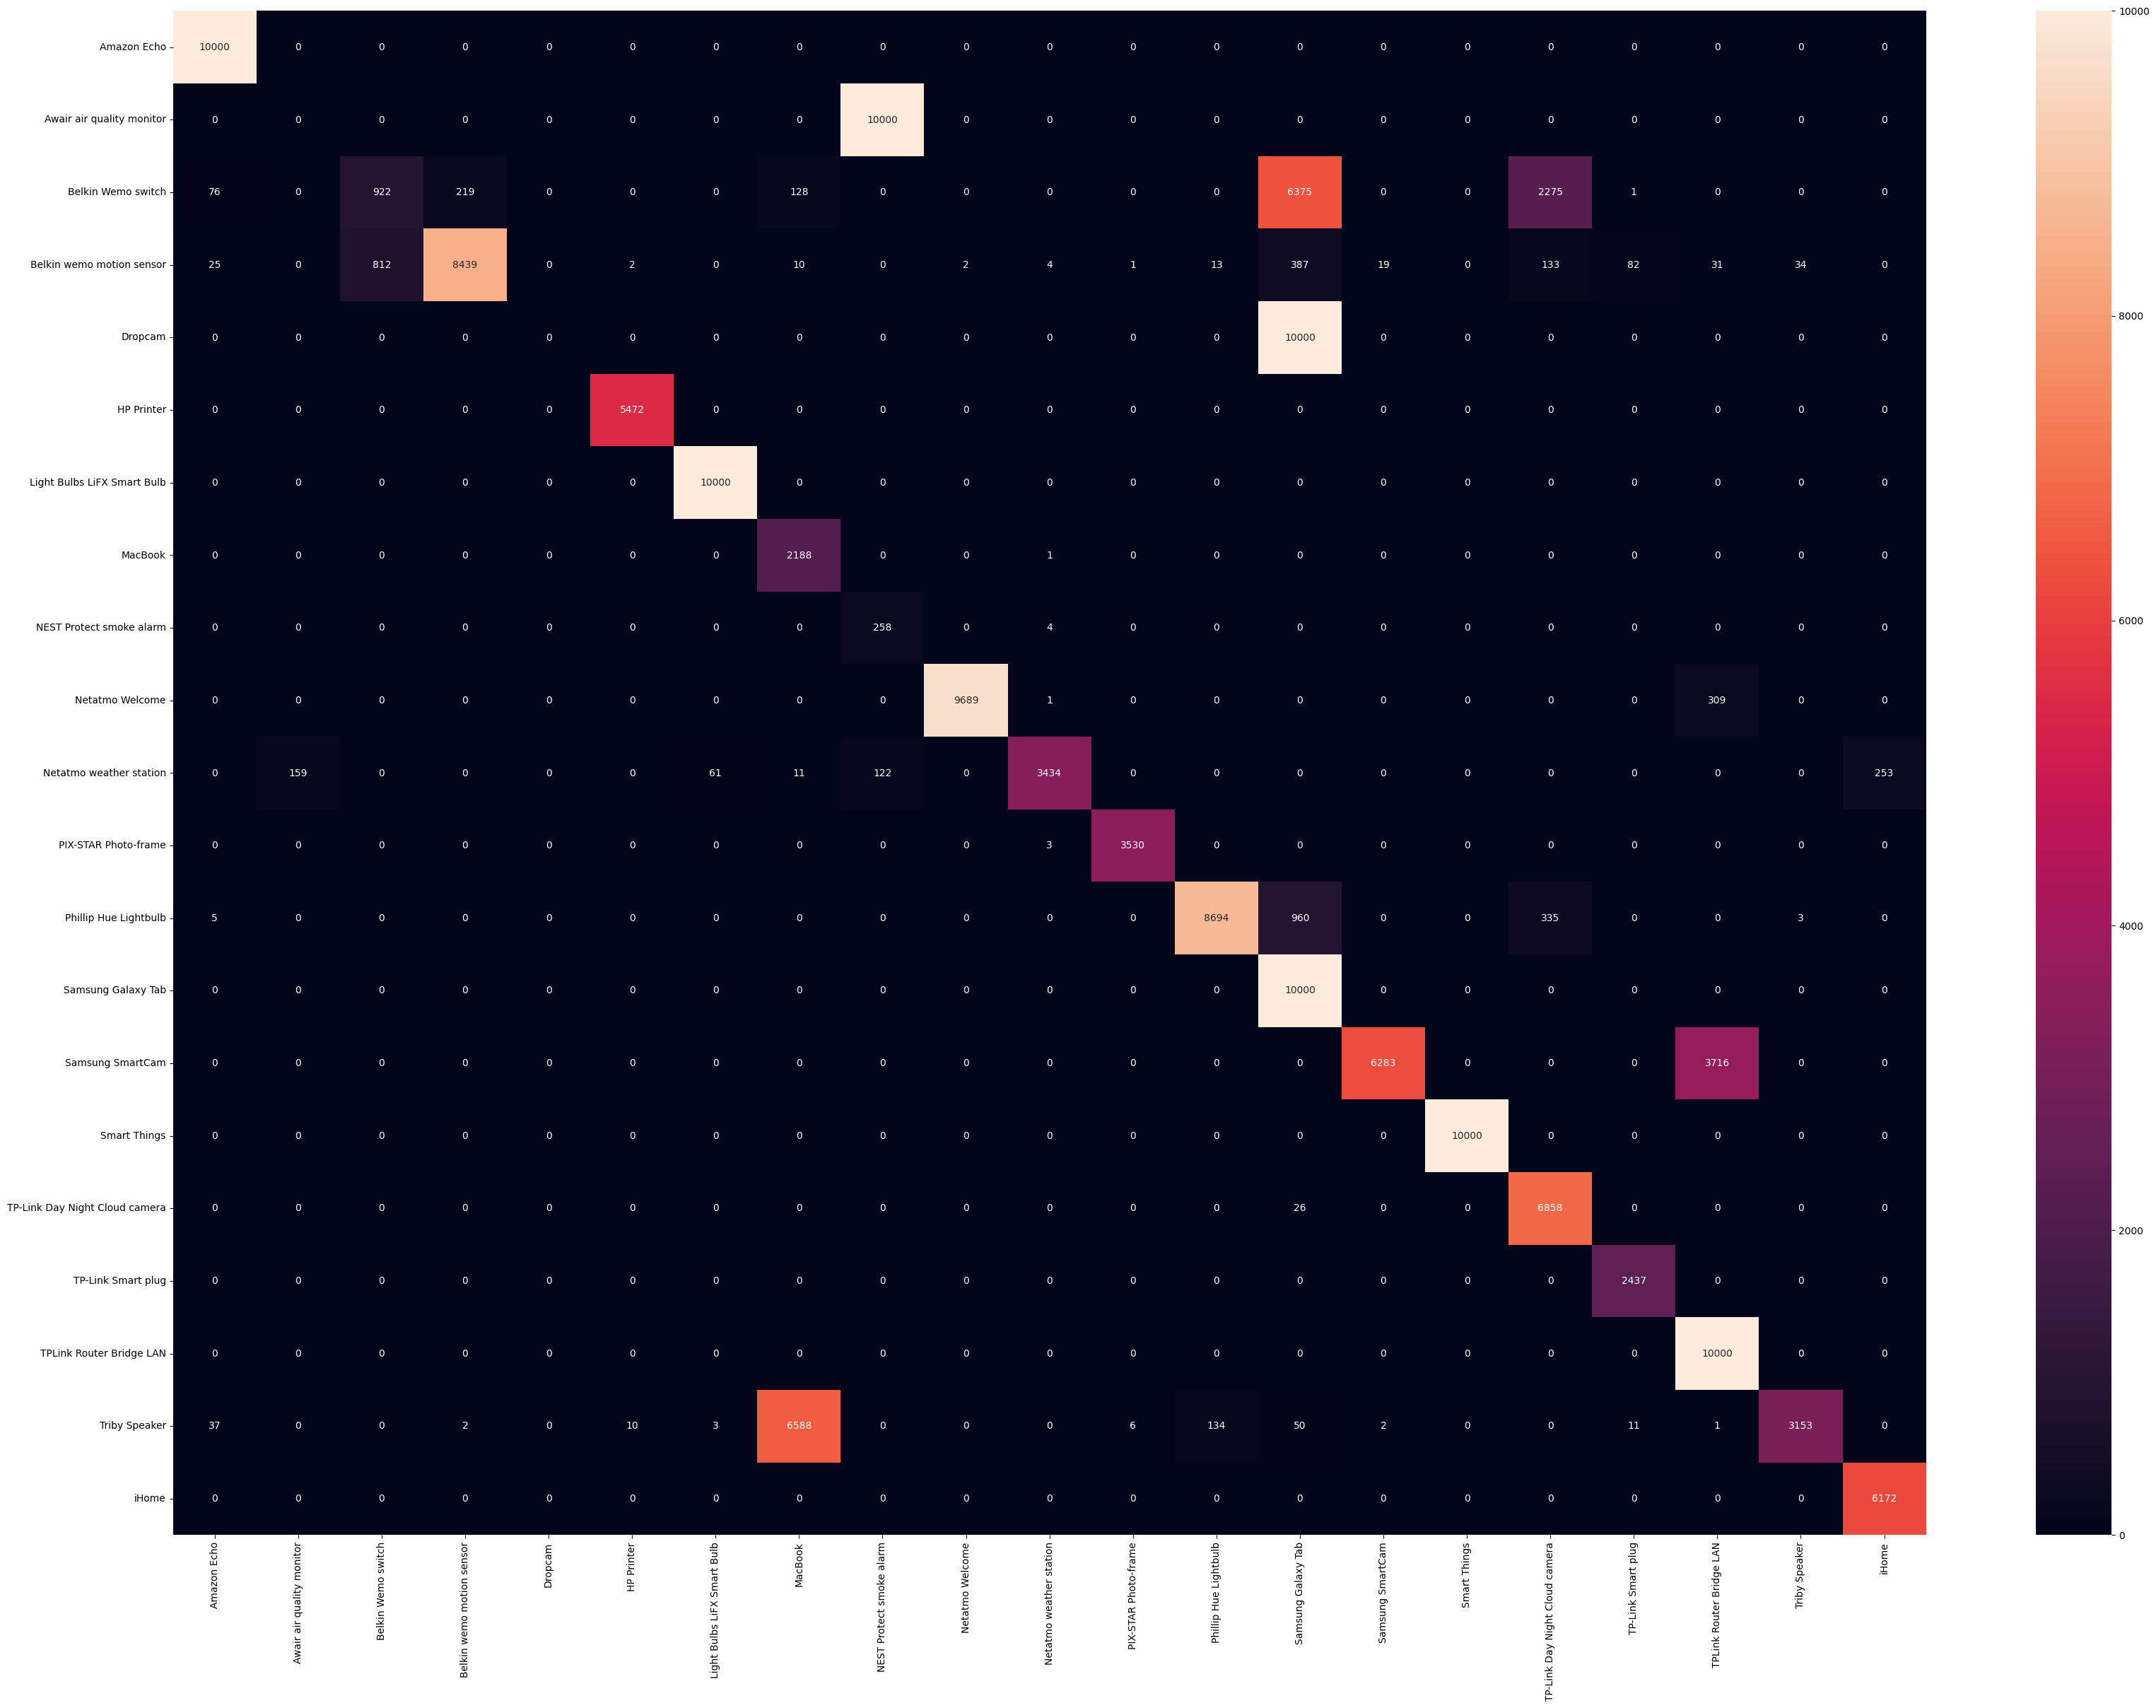

AD-S2-DI-S2
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.741    0.77    0.74   0.77   0.678  0.727      0    0.413     0.051      2.929
 1  results/other/13_13    1     2  DT    0.745    0.773   0.74   0.773  0.682  0.731      0    0.424     0.052      3.042
 2  results/other/13_13    2     3  DT    0.741    0.77    0.739  0.77   0.678  0.727      0    0.437     0.056      2.967
 3  results/other/13_13    3     4  DT    0.743    0.772   0.74   0.772  0.68   0.729      0    0.448     0.055      2.994
 4  results/other/13_13    4     5  DT    0.742    0.771   0.739  0.771  0.678  0.728      0    0.449     0.054      2.994
 5  results/other/13_13    5     6  DT    0.744    0.773   0.739  0.773  0.681  0.73       0    0.447     0.045      3
 6  resu

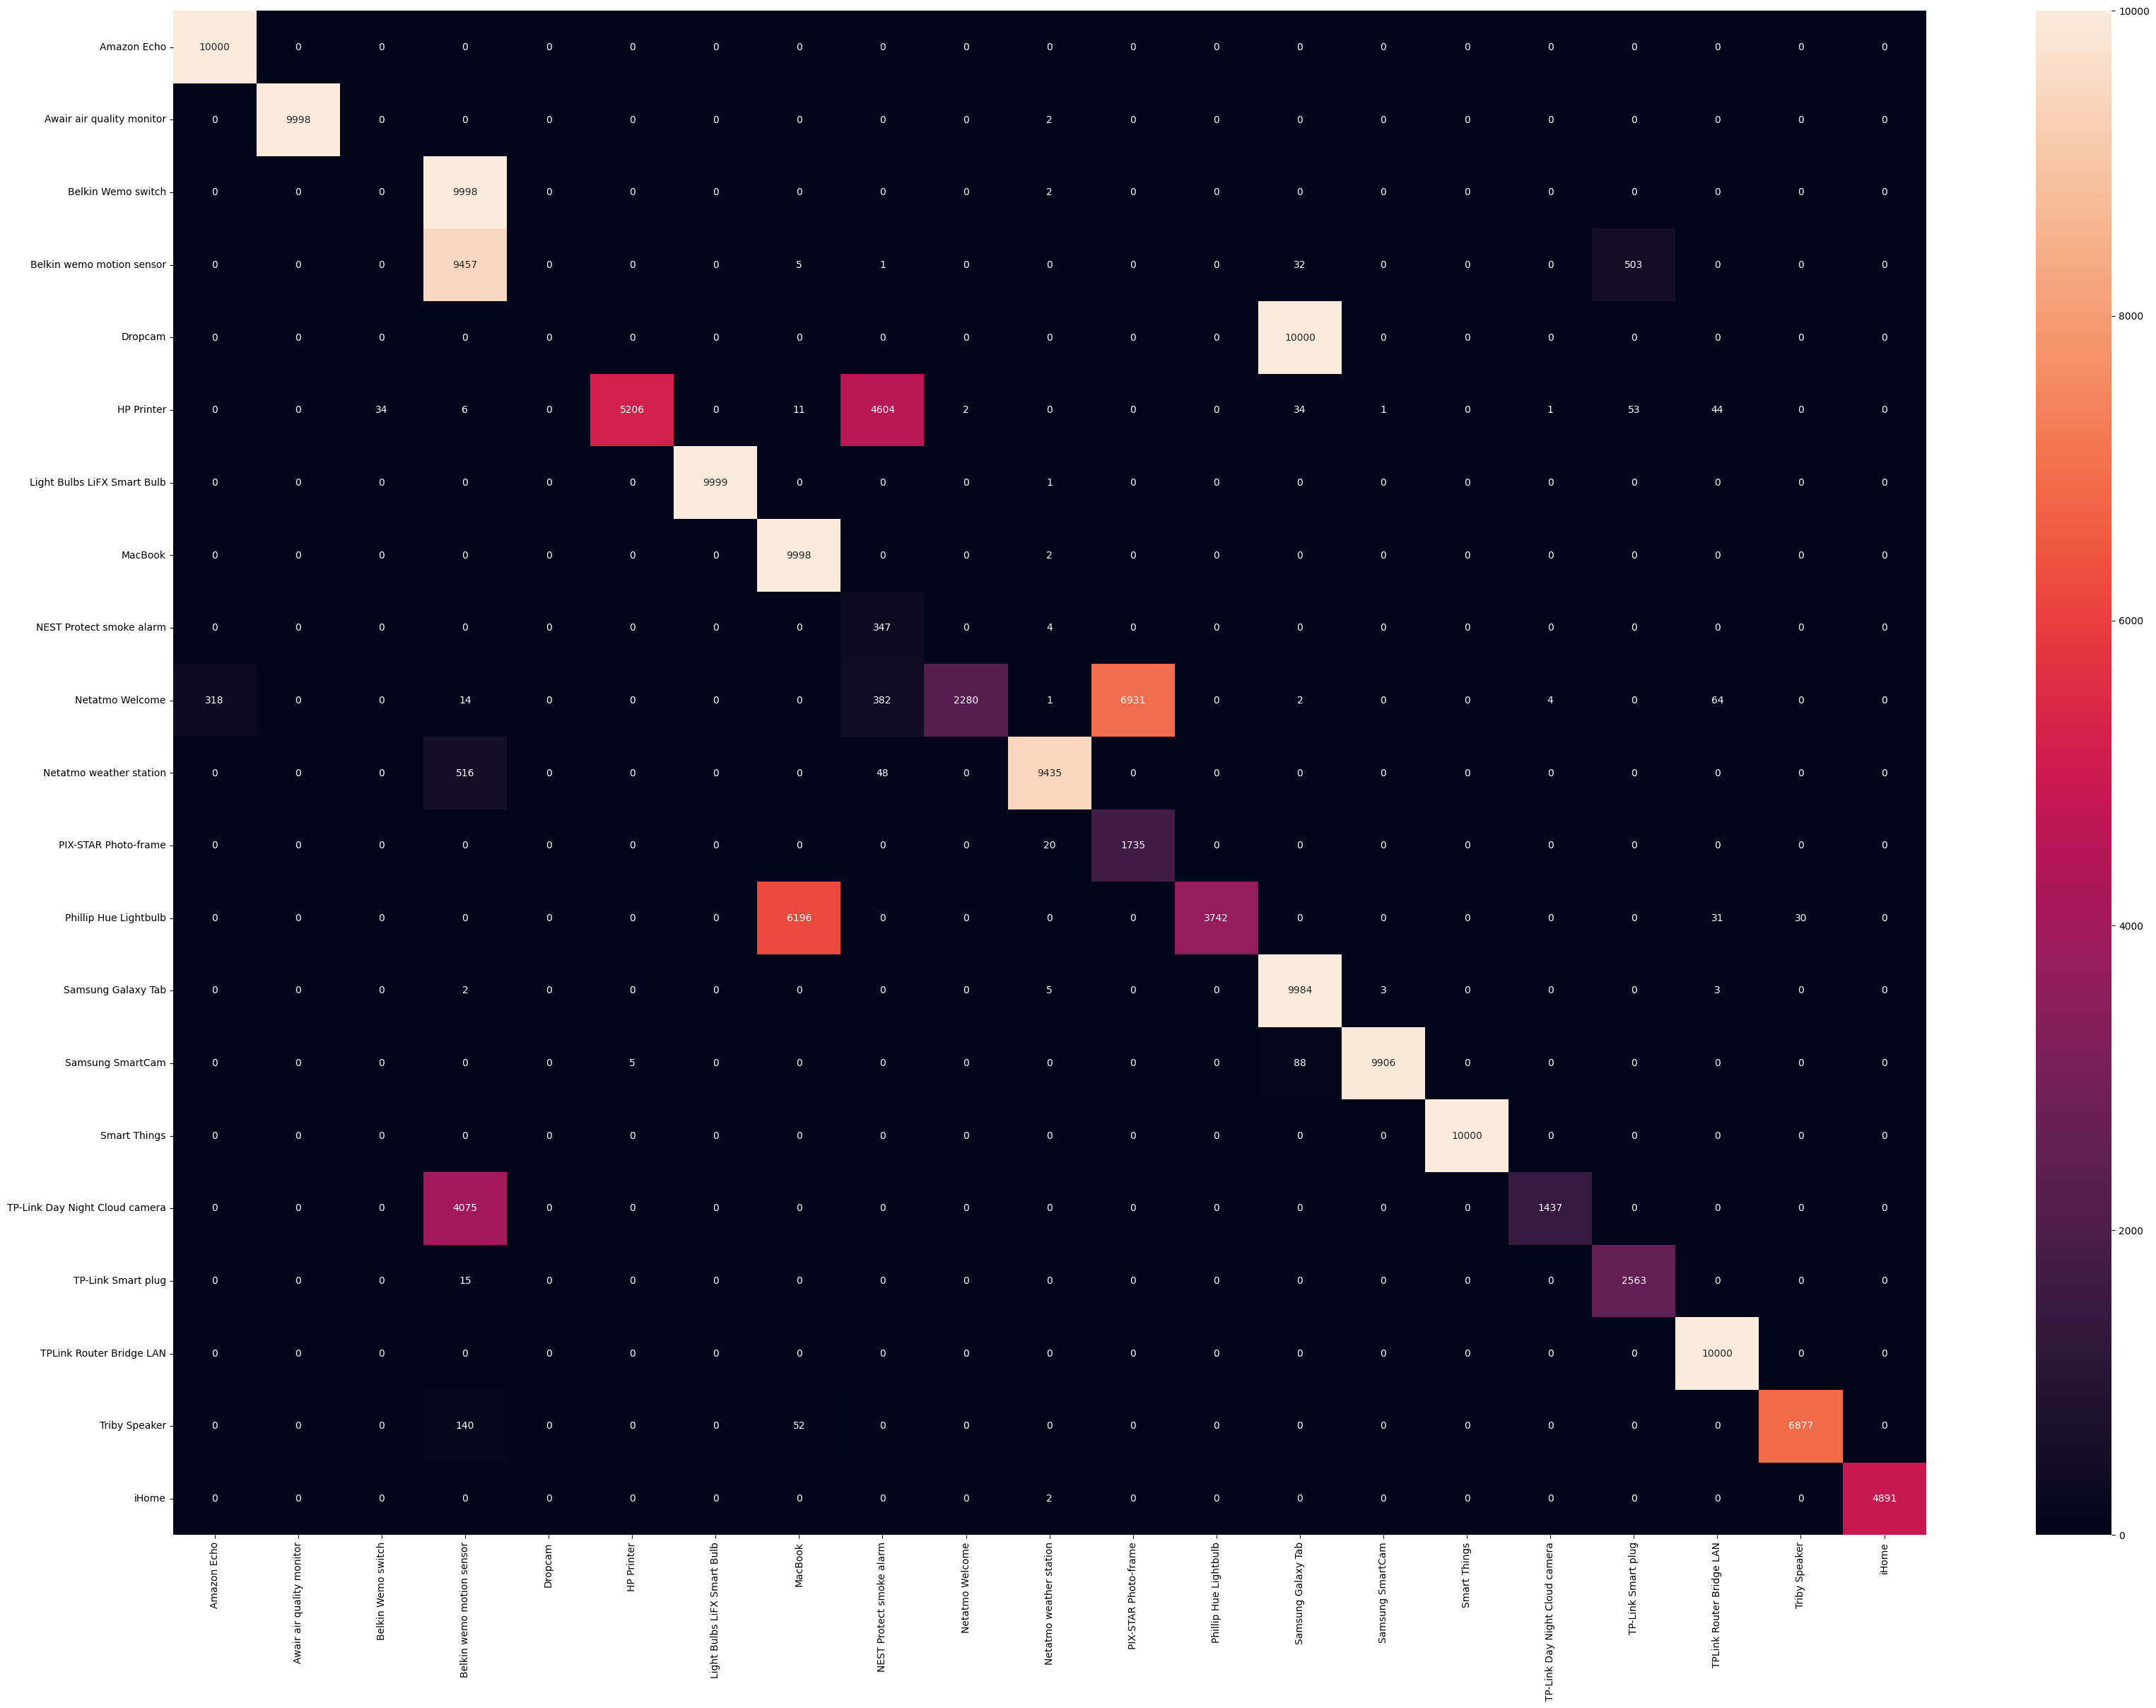

DI-S2-AD-S2
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.791    0.842   0.785  0.842  0.773  0.78       0    0.525     0.049      2.5
 1  results/other/13_13    1     2  DT    0.745    0.798   0.752  0.798  0.74   0.731      0    0.537     0.042      2.612
 2  results/other/13_13    2     3  DT    0.743    0.796   0.729  0.796  0.724  0.729      0    0.527     0.048      2.572
 3  results/other/13_13    3     4  DT    0.793    0.834   0.786  0.834  0.771  0.781      0    0.565     0.046      2.624
 4  results/other/13_13    4     5  DT    0.742    0.796   0.75   0.796  0.737  0.728      0    0.558     0.057      2.684
 5  results/other/13_13    5     6  DT    0.783    0.827   0.78   0.827  0.762  0.772      0    0.557     0.05       2.629
 6  re

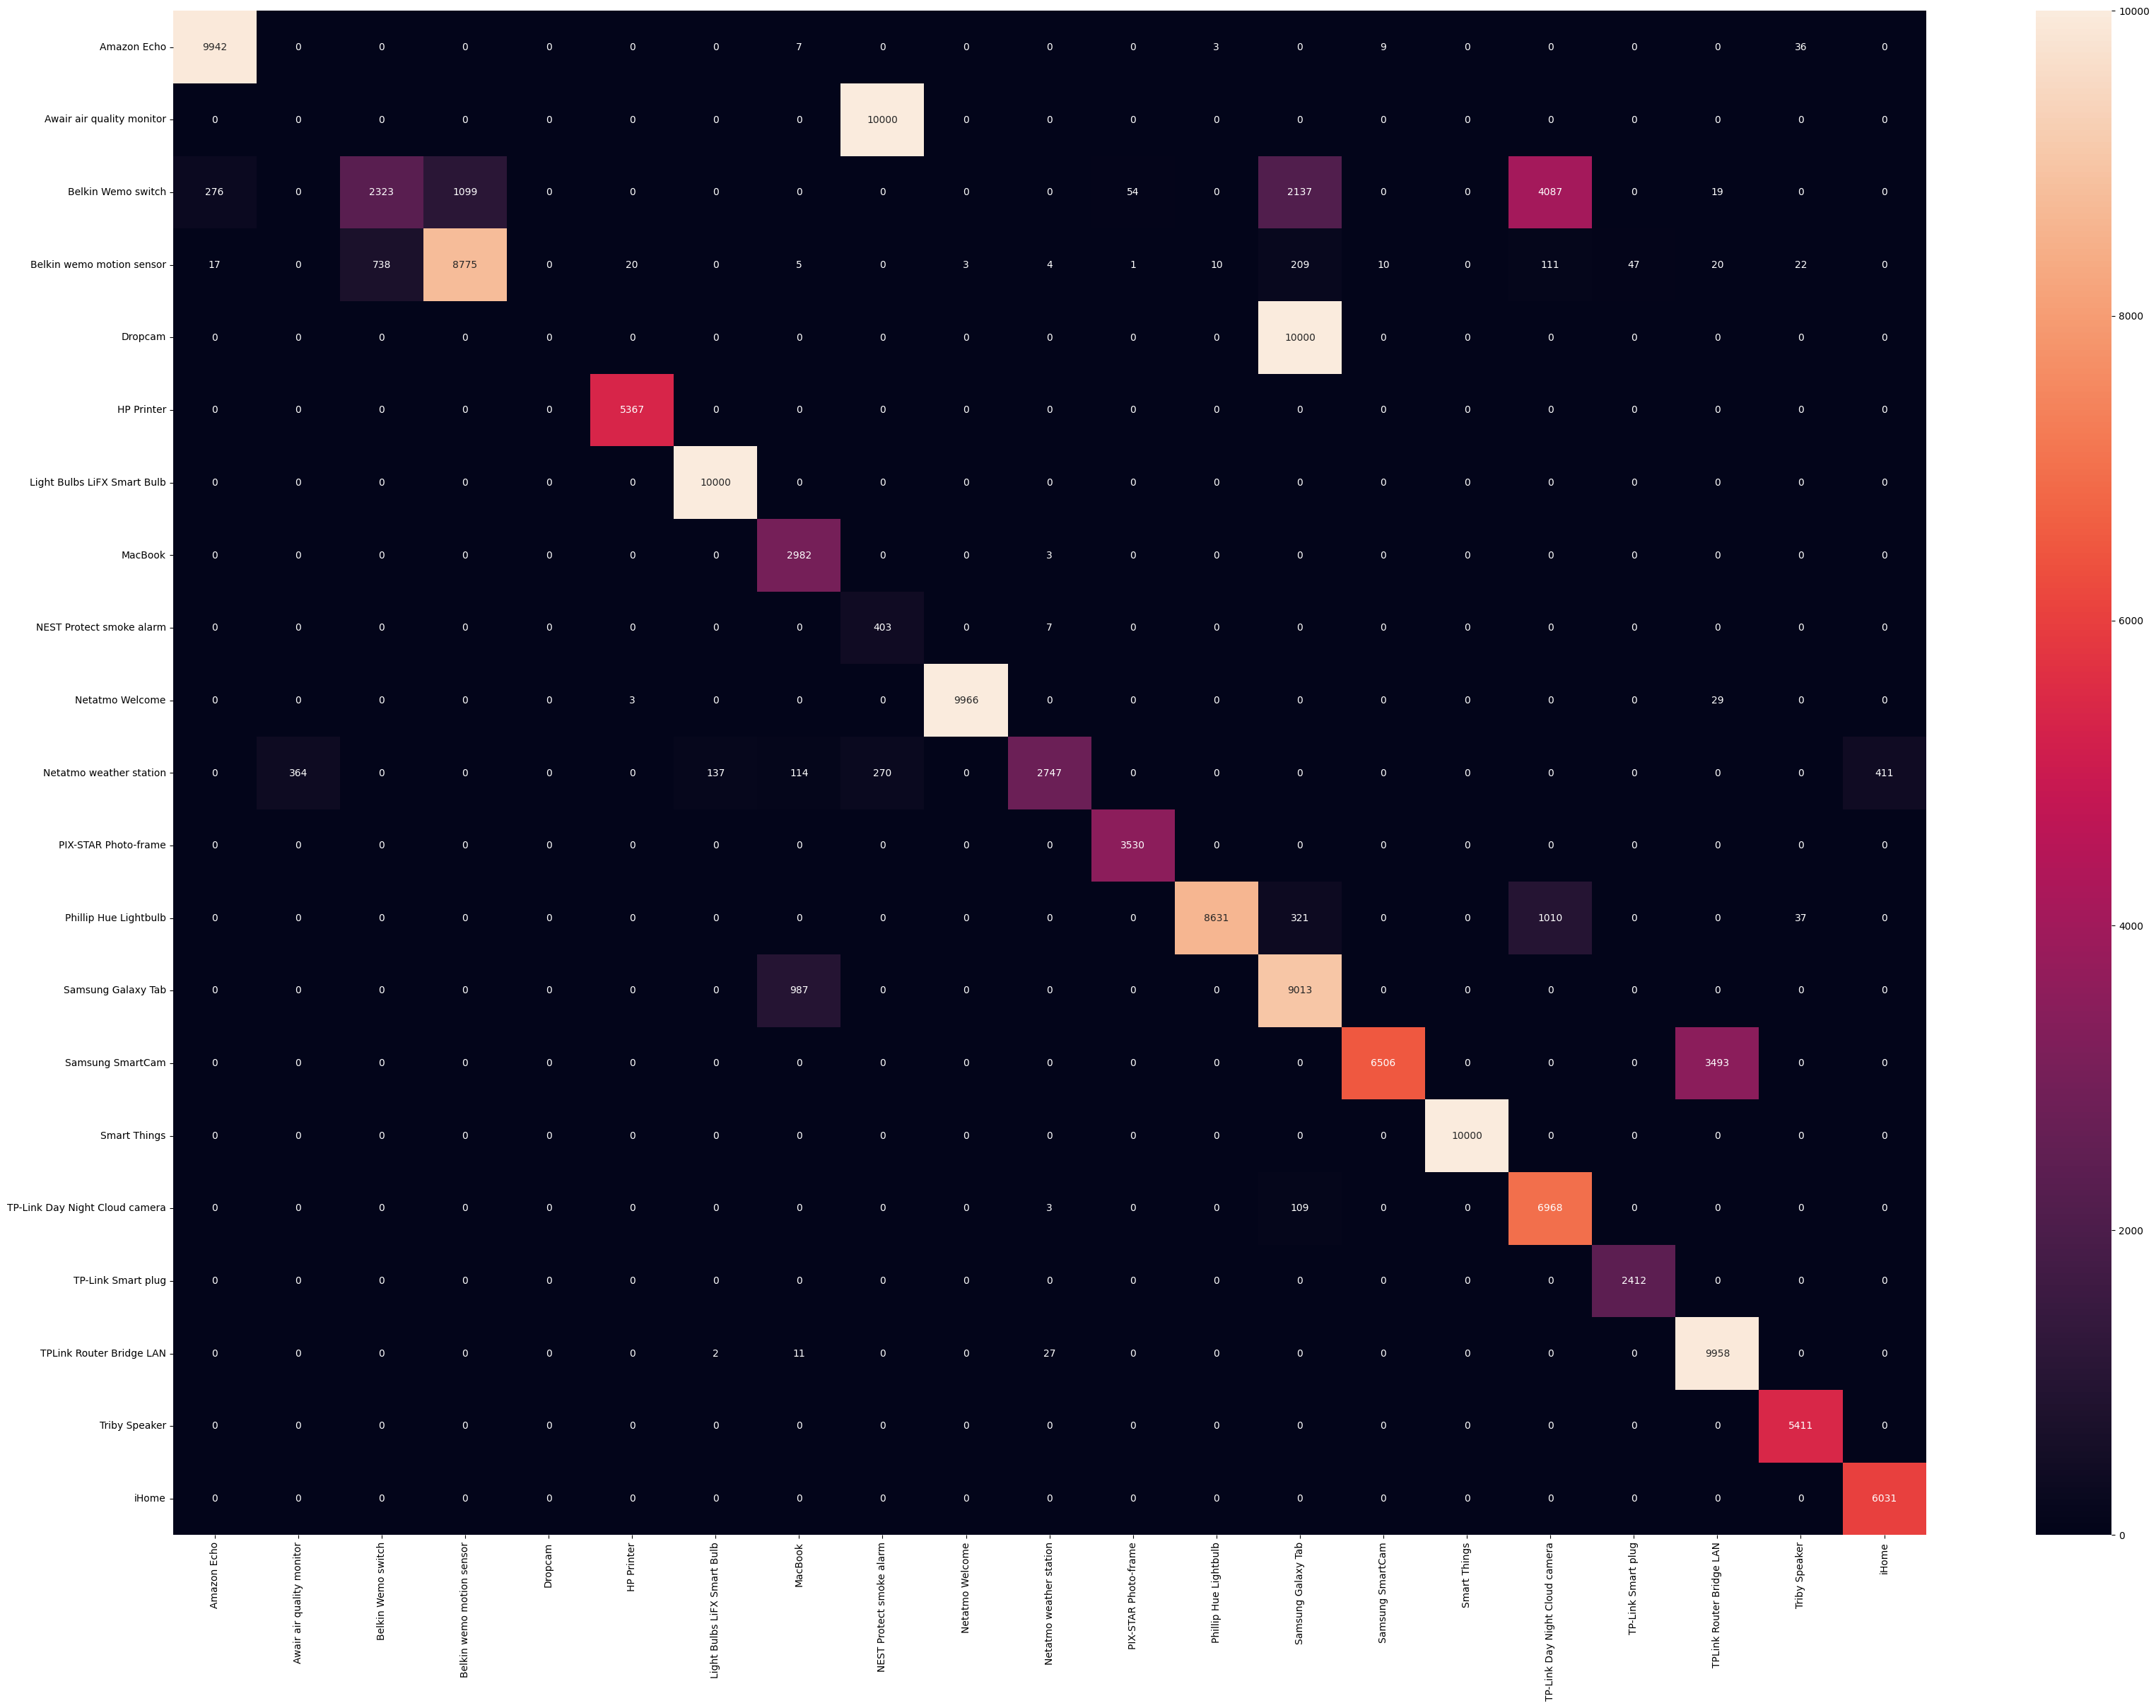

AD-S2-DI-S1
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.729    0.756   0.744  0.756  0.669  0.714      0    0.404     0.057      2.804
 1  results/other/13_13    1     2  DT    0.731    0.758   0.743  0.758  0.67   0.716      0    0.43      0.05       2.783
 2  results/other/13_13    2     3  DT    0.711    0.741   0.695  0.741  0.654  0.695      0    0.429     0.052      2.923
 3  results/other/13_13    3     4  DT    0.712    0.742   0.696  0.742  0.654  0.696      0    0.419     0.033      2.968
 4  results/other/13_13    4     5  DT    0.726    0.753   0.727  0.753  0.667  0.711      0    0.423     0.041      2.893
 5  results/other/13_13    5     6  DT    0.729    0.757   0.744  0.757  0.669  0.715      0    0.439     0.05       2.869
 6  

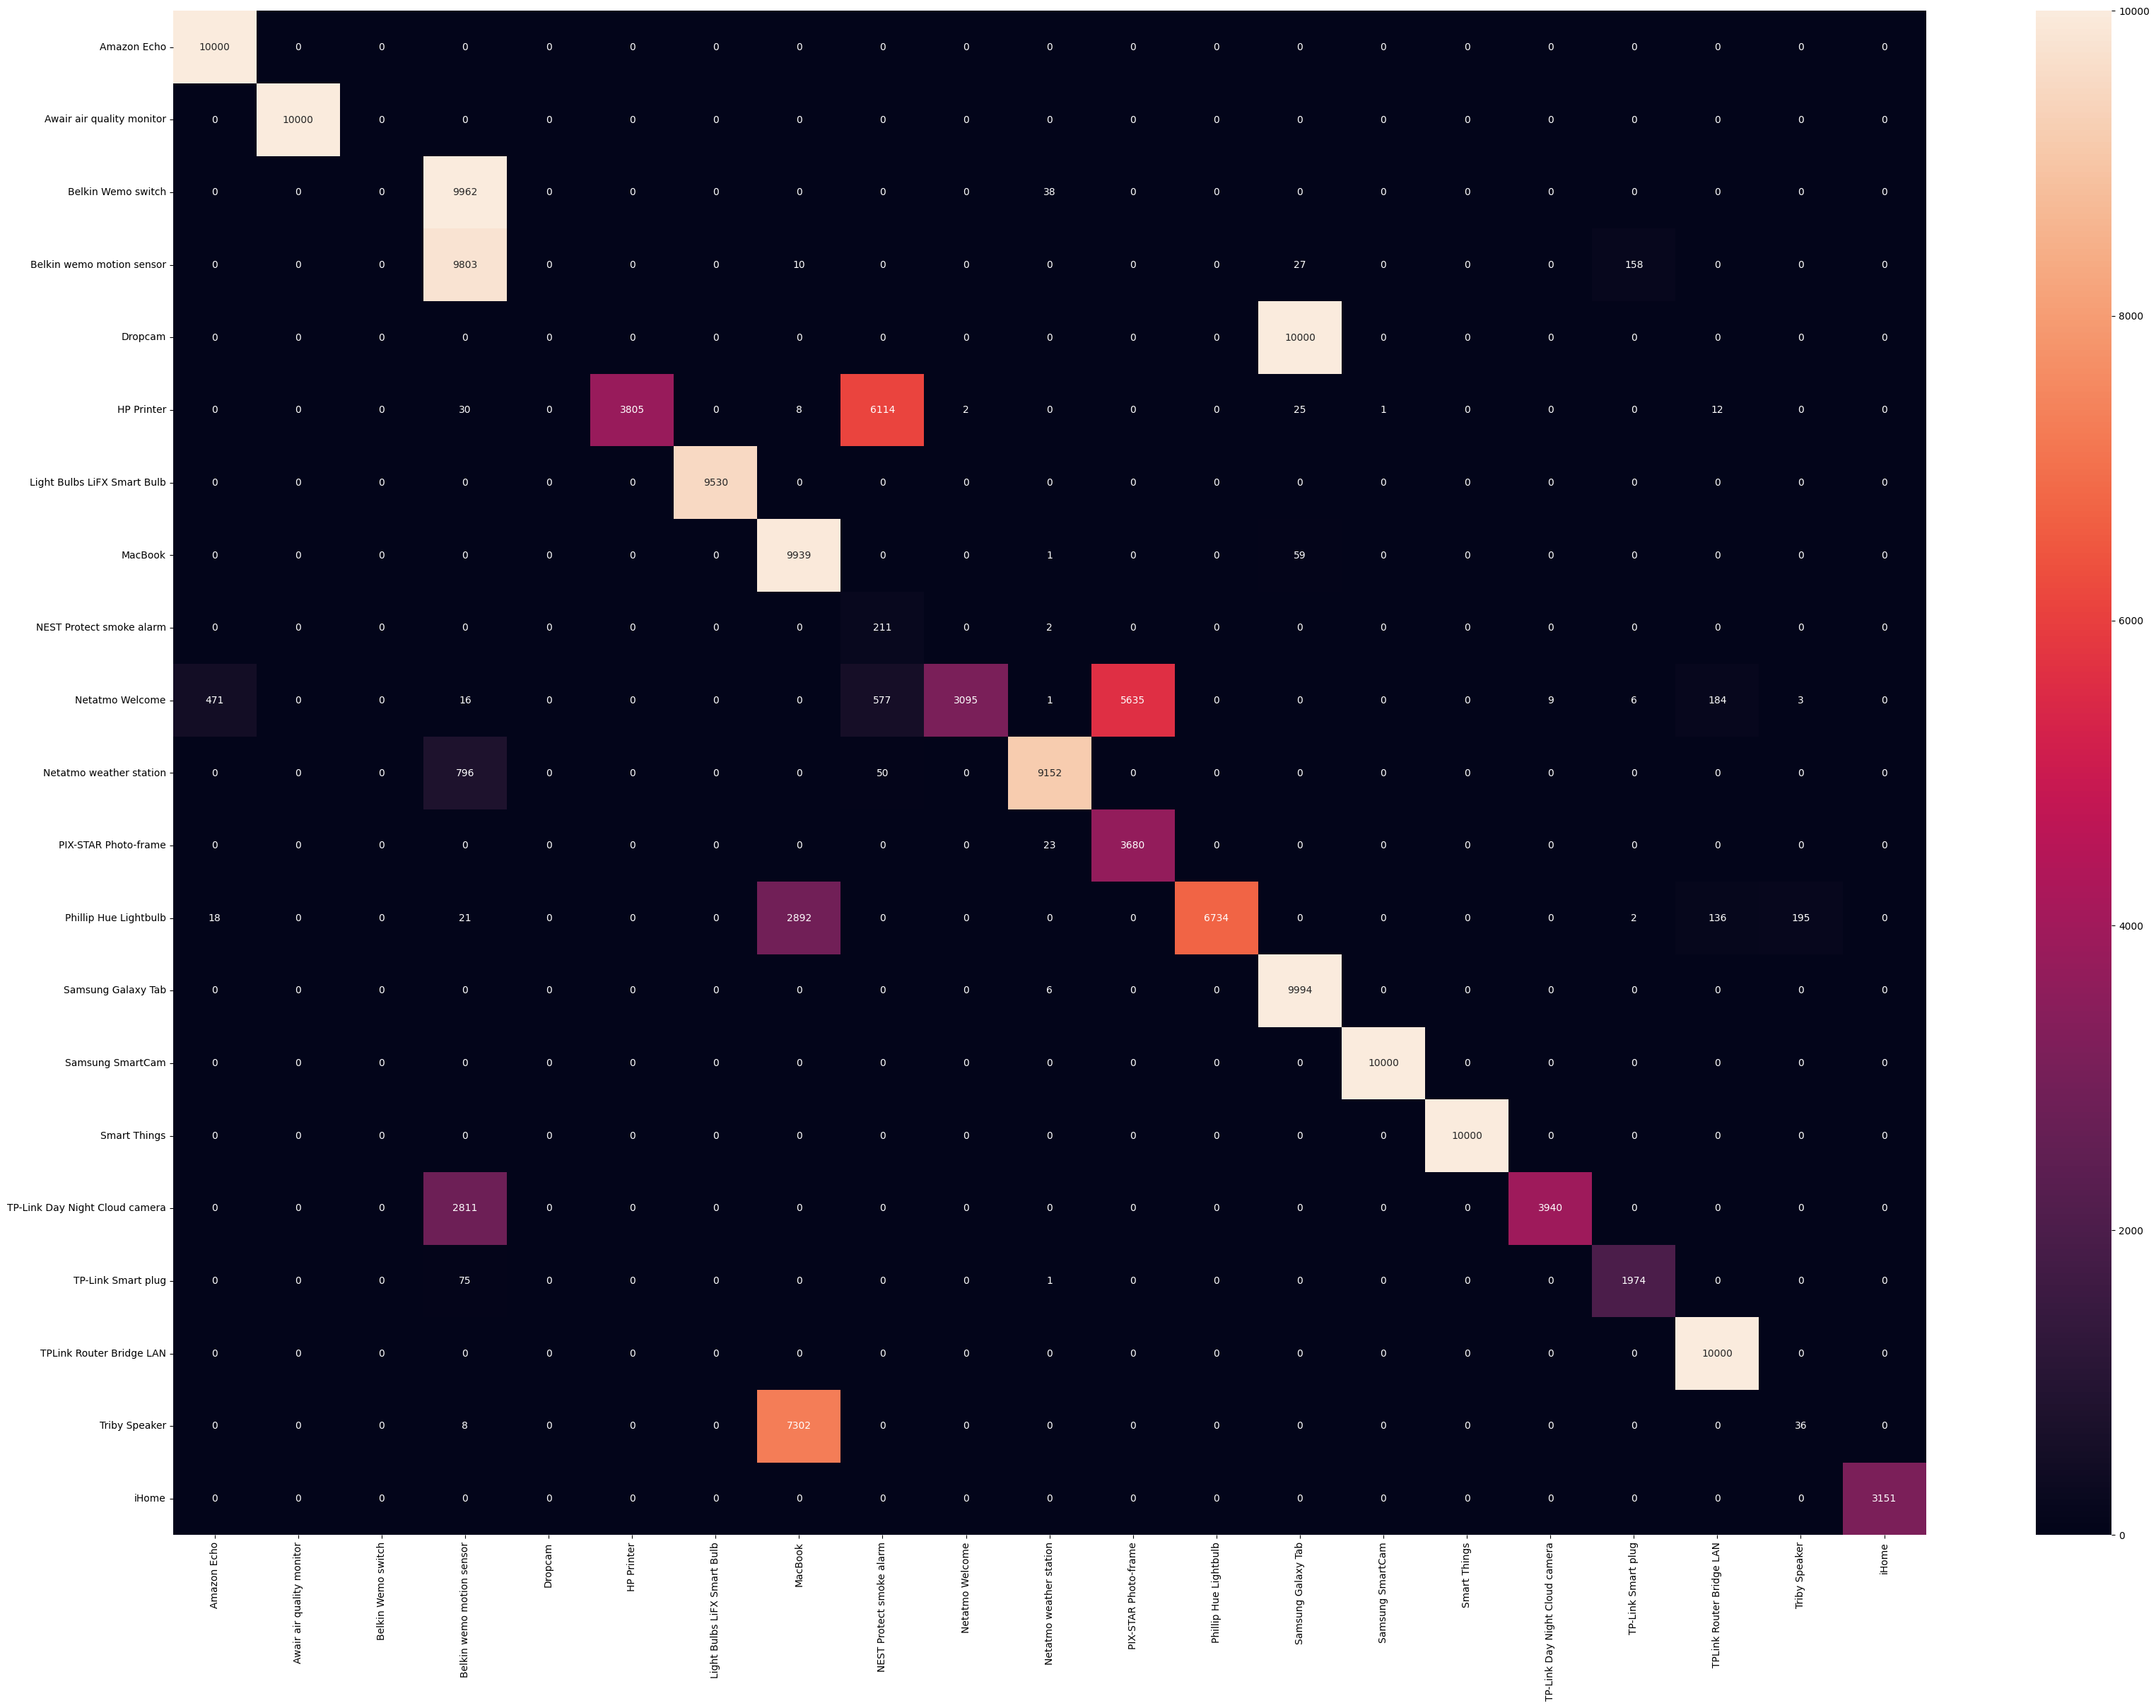

DI-S1-AD-S2
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.744    0.801   0.732  0.801  0.729  0.73       0    0.549     0.053      2.761
 1  results/other/13_13    1     2  DT    0.745    0.804   0.731  0.804  0.73   0.731      0    0.553     0.047      2.757
 2  results/other/13_13    2     3  DT    0.745    0.802   0.731  0.802  0.729  0.731      0    0.562     0.048      2.749
 3  results/other/13_13    3     4  DT    0.763    0.815   0.745  0.815  0.745  0.75       0    0.547     0.046      2.749
 4  results/other/13_13    4     5  DT    0.742    0.799   0.722  0.799  0.717  0.729      0    0.551     0.052      2.776
 5  results/other/13_13    5     6  DT    0.762    0.815   0.732  0.815  0.732  0.75       0    0.562     0.053      2.776
 6  

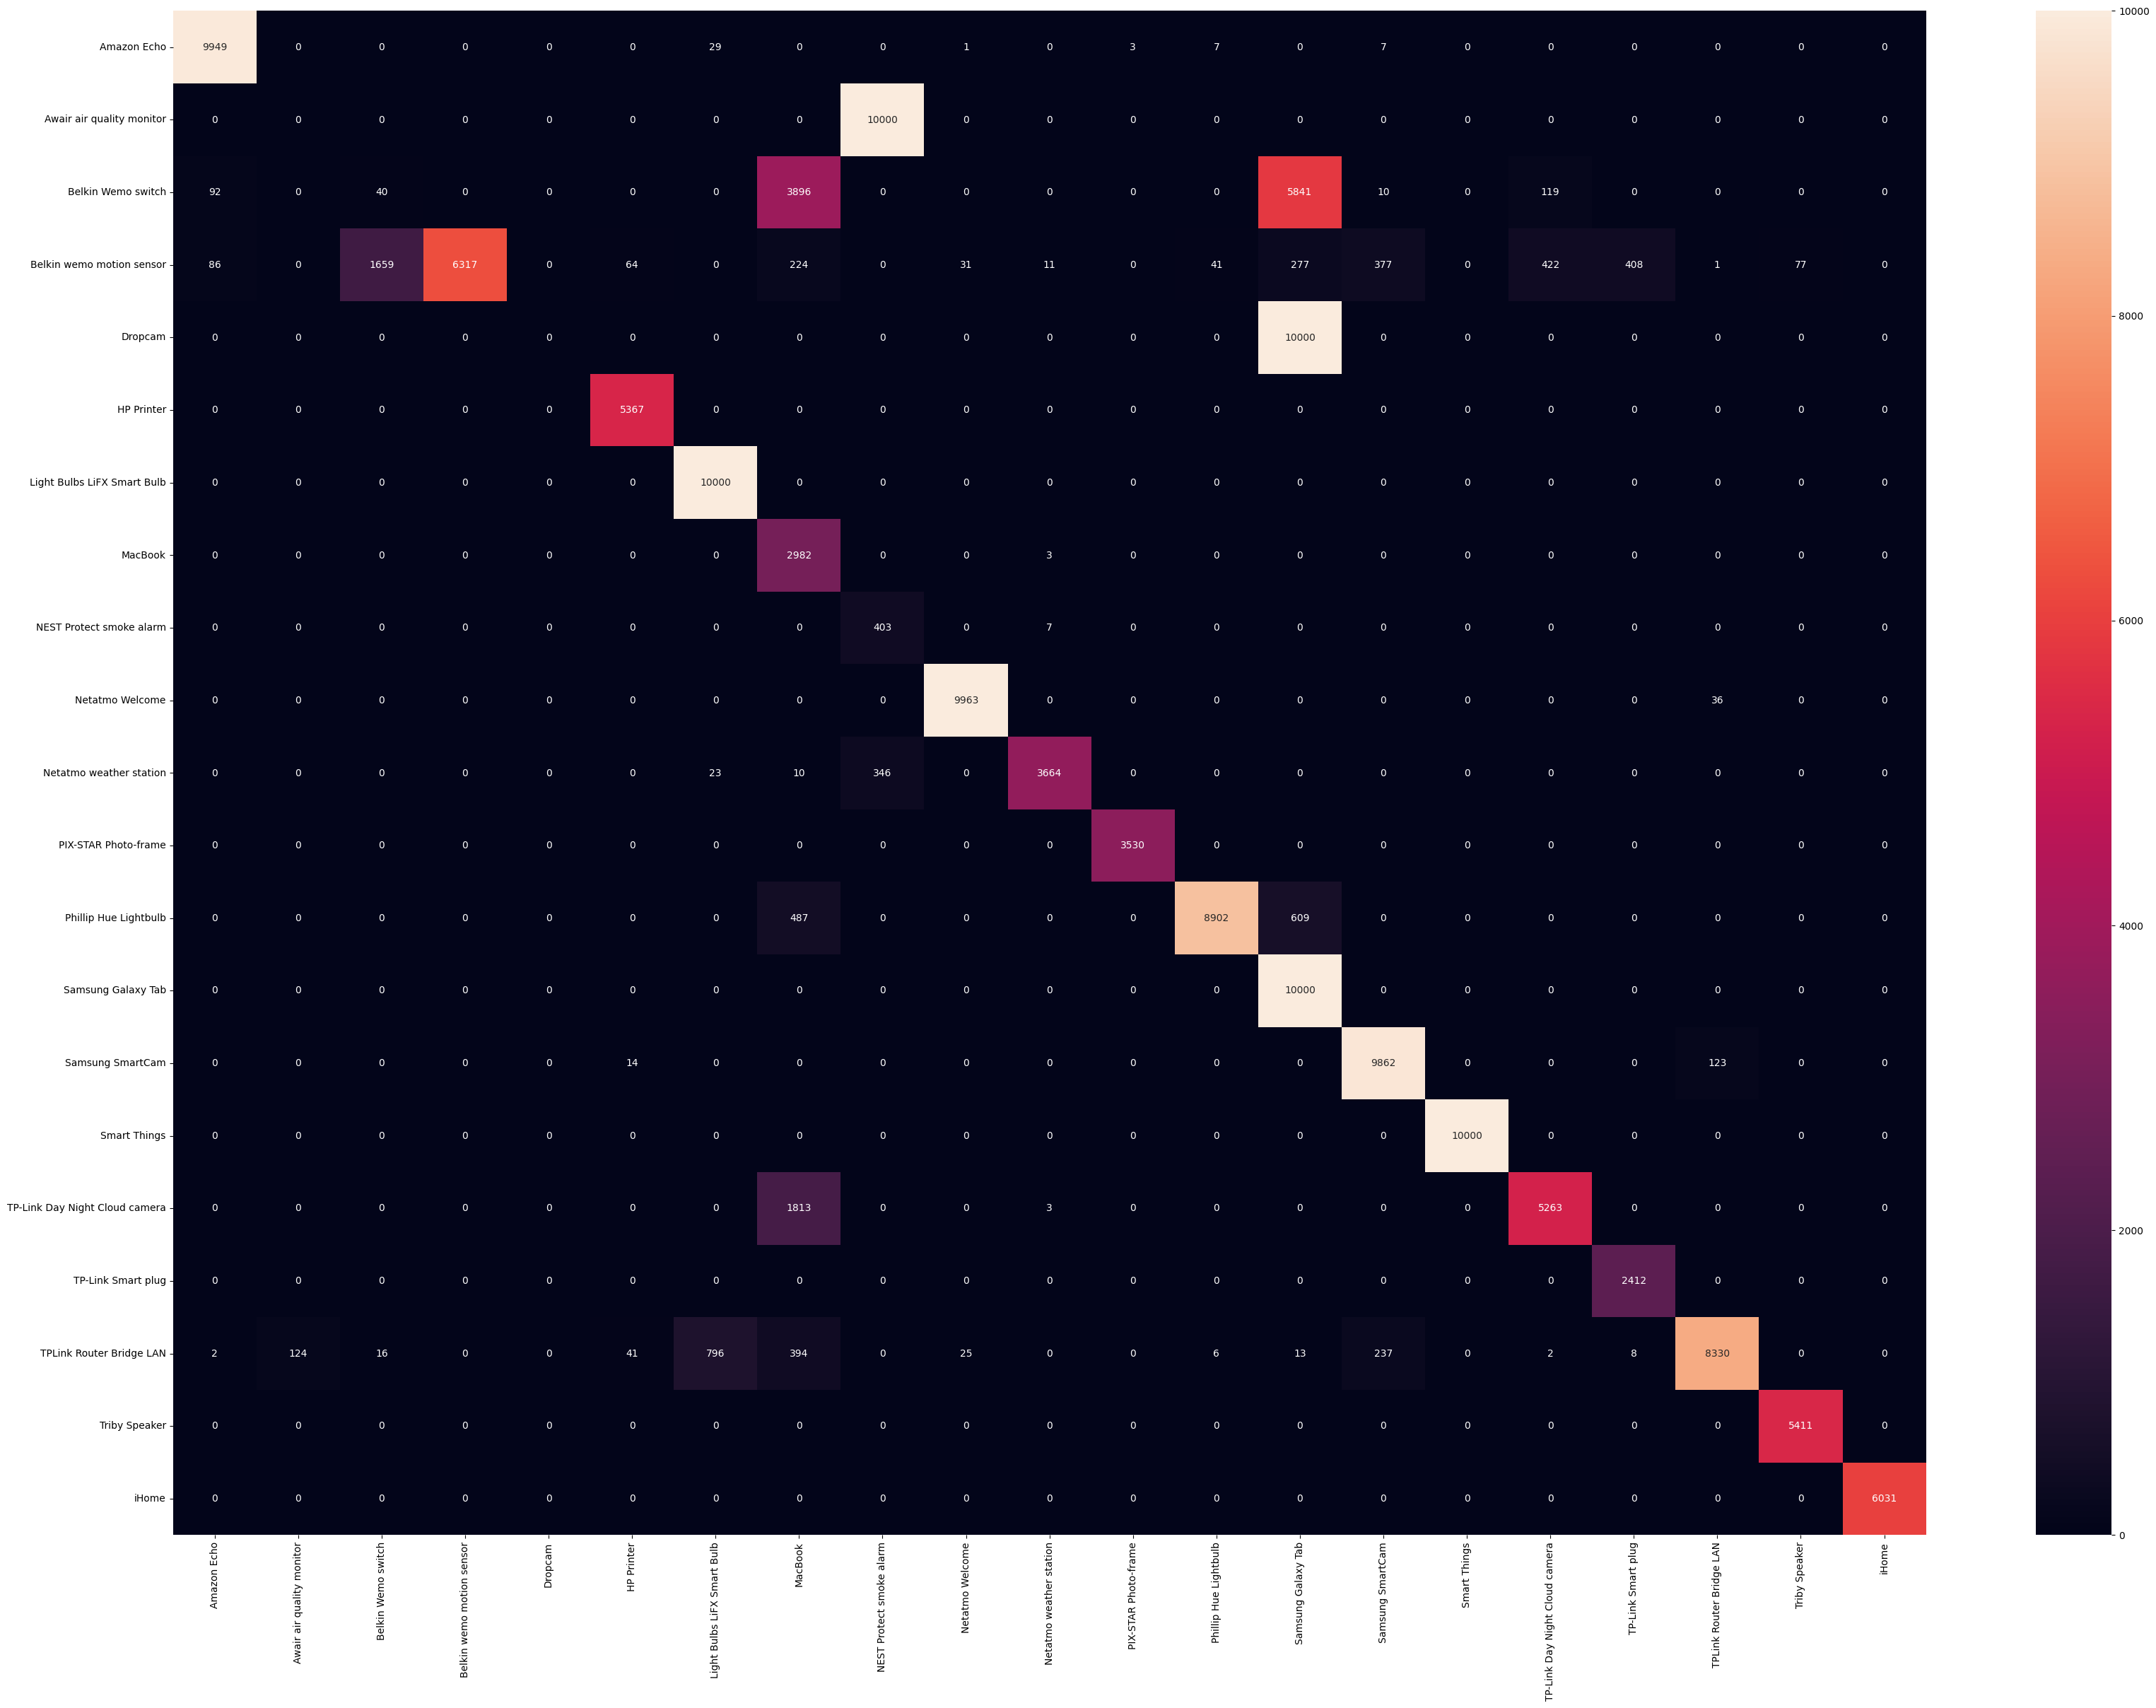

In [21]:
say=0
dataset="./results/other/13/"
folder(dataset)
folder(dataset)
for ii in file_list:
        say+=1
        train=file_list[ii][0]
        test=file_list[ii][1]
        mixed=True
        step=13
        sayac=1
        output_csv=f"{dataset}/@{file_list[ii][0][8:-4]}@{file_list[ii][1][8:-4]}.csv"
        print(f"{file_list[ii][0][8:-4]}-{file_list[ii][1][8:-4]}")
        target_names=target_name(test)
        ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   
